# $M\to\infty$ Transformer

In [163]:
import os
from dotenv import load_dotenv

load_dotenv();

In [194]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import seaborn as sns
from sklearn.decomposition import PCA
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA

# import sys
# del sys.modules['icl.figures.colors']
# del sys.modules['icl.figures.notation']

from icl.analysis.utils import get_unique_run
from icl.constants import ANALYSIS, FIGURES, SWEEPS
from icl.figures.notation import str_d_dlogt, str_d_dt, str_dlog_dlogt
from icl.figures.colors import plot_transitions, gen_transition_colors, get_transition_type, PRIMARY, SECONDARY, TERTIARY, BRED, BBLUE, BRED, BGREEN
from icl.setup import DEVICE

MODEL_ID = "L2H4Minf"
LLC_RUN_ID = "5e0cq1db"  # TODO: Placeholder from m=20

sns.set_style('white')
DEVICE

device(type='mps')

In [ ]:
NUM_TASKS = 2 ** 20  # TODO: Placeholder
NUM_LAYERS = 2
MAX_LR = 0.01

# shorthands
BATCH_SIZE = 8192
K = 8
D = 4

run = get_unique_run(
    str(SWEEPS / "training-runs/small-L-2.yaml"), 
    task_config={"num_tasks": NUM_TASKS, "num_layers": NUM_LAYERS},
    optimizer_config={"lr": MAX_LR}
)

In [ ]:
from copy import deepcopy 
# Let's generate these same plots and also look at their evolution. 
models = []
optimizer_state_dicts = []

steps = run.checkpointer.file_ids

for checkpoint in tqdm.tqdm(run.checkpointer):
    m = deepcopy(run.model)
    m.load_state_dict(checkpoint["model"])
    models.append(m)
    optimizer_state_dicts.append(checkpoint["optimizer"])


In [ ]:
# Let's look at how the curvature of the llc changes over time. 

import wandb

api = wandb.Api()
llc_run = api.run(f"devinterp/icl/{LLC_RUN_ID}")
history_df = llc_run.history()

llc_steps = history_df["_step"]
llcs = history_df["llc/mean"]
llcs_std = history_df["llc/std"]


In [ ]:
from icl.figures.derivatives import d_dt, d_dlogt, dlog_dlogt

weight_norms = [(sum(torch.norm(p) ** 2 for p in model.parameters()) ** 0.5).item() for model in models]

d_llc_dt = d_dt(steps, llcs)
d_llc_dlogt = d_dlogt(steps, llcs)

d_weight_norm_dt = d_dt(run.checkpointer.file_ids, weight_norms)
d_weight_norm_dlogt = d_dlogt(run.checkpointer.file_ids, weight_norms)

In [ ]:
from icl.evals import ICLEvaluator

FORCE_REEVAL = True

evaluator = ICLEvaluator(
    pretrain_dist=run.pretrain_dist,
    true_dist=run.true_dist,
    max_examples=run.config.task_config.max_examples,
    eval_batch_size=BATCH_SIZE,
    seed=run.config.task_config.true_seed,   
)

if os.path.exists(ANALYSIS / f"{MODEL_ID}_evals_over_time.csv") and not FORCE_REEVAL:
    evals_over_time_df = pd.read_csv(ANALYSIS / f"{MODEL_ID}_evals_over_time.csv")
    evals_over_time = evals_over_time_df.to_dict("records")
else:
    evals_over_time = [evaluator(model) for model in models]
    evals_over_time_df = pd.DataFrame(evals_over_time)
    evals_over_time_df.to_csv(ANALYSIS / f"{MODEL_ID}_evals_over_time.csv")

evals_over_time_df

In [ ]:
evals_over_time_df.columns

In [172]:
steps

[0,
 1,
 2,
 3,
 4,
 6,
 8,
 11,
 14,
 19,
 24,
 32,
 42,
 55,
 72,
 94,
 124,
 162,
 211,
 276,
 362,
 473,
 618,
 808,
 1056,
 1381,
 1805,
 2359,
 3084,
 4031,
 5269,
 6887,
 9003,
 10204,
 11767,
 15381,
 20104,
 20408,
 26279,
 30612,
 34349,
 40816,
 44897,
 51020,
 58684,
 61224,
 71428,
 76706,
 81632,
 91836,
 100262,
 102040,
 112244,
 122448,
 131051,
 132653,
 142857,
 153061,
 163265,
 171296,
 173469,
 183673,
 193877,
 204081,
 214285,
 223899,
 224489,
 234693,
 244897,
 255102,
 265306,
 275510,
 285714,
 292657,
 295918,
 306122,
 316326,
 326530,
 336734,
 346938,
 357142,
 367346,
 377551,
 382529,
 387755,
 397959,
 408163,
 418367,
 428571,
 438775,
 448979,
 459183,
 469387,
 479591,
 489795,
 499999]

In [381]:
import colorsys
from matplotlib.colors import LinearSegmentedColormap


# TRANSITIONS = [
#     (30, 1200, 'A1'),
#     (1200, 12500, 'A2'),
#     (12500, 60000, 'B1'),
#     (60000, 110000, 'B2'),
#     (110000, 180000, 'B3'),
#     (180000, 280000, "B4"),
#     (280000, 320000, "B5"),
#     (320000, 500000, "B6")
# ]


TRANSITIONS = [
    # PCA-based
    # (0, 600, 'A1a'),
    # (600, 2000, 'A1b'),
    # (2000, 3000, 'A2a'),
    # (3000, 15000, 'A2b'),
    # (15000, 28000, 'B1a'),
    # (28000, 60000, 'B1b'),
    # (60000, 140000, 'B2a'),
    # (140000, 500000, 'B2b'),
    # LLC-based
    (0, 600, 'A1a'),
    (600, 1200, 'A1b'),
    (1200, 4000, 'A2a'),
    (4000, 15000, 'A2b'),
    (15000, 28000, 'B1a'),
    (28000, 60000, 'B1b'),
    (60000, 120000, 'B2a'),
    (120000, 500000, 'B2b'),
    # (110000, 180000, 'B3'),
    # (180000, 280000, "B4"),
    # (280000, 320000, "B5"),
    # (320000, 500000, "B6")
]

# def gen_transition_colors(types):
#     """Generates a palette for transition colors. Orange-flavored for Type A. Blue-flavored for Type B."""
#     num_type_a = sum([t == "A" for t in types])
#     num_type_b = sum([t == "B" for t in types])
#     num_other = sum([t == "Other" for t in types])

#     type_a_palette = sns.color_palette("Oranges_r", num_type_a)
#     type_b_palette = sns.color_palette("Blues_r", num_type_b)
#     other_palette = sns.color_palette("Greys_r", num_other)

#     palette = []

#     for t in types:
#         if t == "A":
#             palette.append(type_a_palette.pop())
#         elif t == "B":
#             palette.append(type_b_palette.pop())
#         else:
#             palette.append(other_palette.pop())

#     return palette


def increase_saturation(rgb, saturation_factor):
    # Convert RGB to HSV
    hsv = colorsys.rgb_to_hsv(*rgb)
    
    # Increase saturation by the given factor, making sure it stays in [0, 1]
    new_s = min(max(hsv[1] * saturation_factor, 0), 1)
    
    # Convert back to RGB
    new_rgb = colorsys.hsv_to_rgb(hsv[0], new_s, hsv[2])
    return new_rgb


def increase_contrast(rgb, contrast_factor):
    # Midpoint
    midpoint = 128.0 / 255
    
    # Increase contrast
    new_rgb = [(0.5 + contrast_factor * (component - 0.5)) for component in rgb]
    
    # Clip to the range [0, 1]
    new_rgb = [min(max(component, 0), 1) for component in new_rgb]
    return new_rgb



transition_types = [get_transition_type(t) for t in TRANSITIONS]
transition_colors = gen_transition_colors(transition_types)

transition_colors = [increase_saturation(rgb, 2) for rgb in transition_colors]
transition_colors = [increase_contrast(rgb, 2) for rgb in transition_colors]

transitions_cmap = LinearSegmentedColormap.from_list("transitions", transition_colors)

/Users/Jesse/Projects/icl/icl/figures/colors.py:70: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(min_step, max_step)


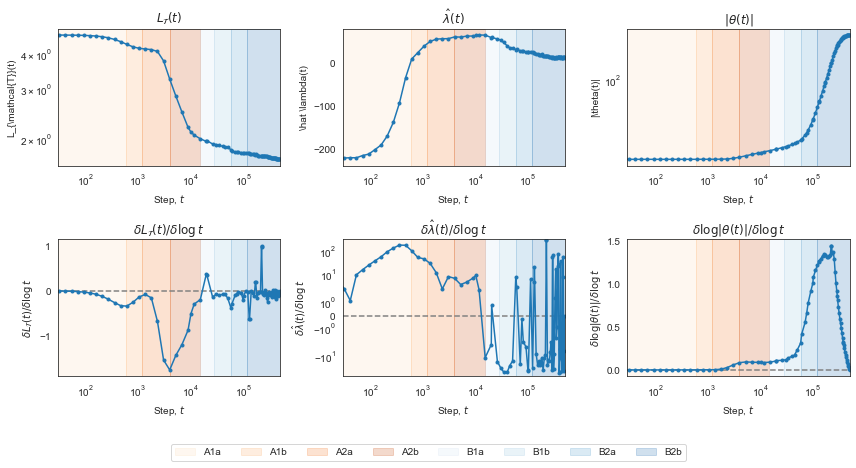

In [382]:
metrics_to_plot = [
    (r"L_{\mathcal{T}}(t)", evals_over_time_df["pretrain/mse_subsequence"], {"logy": True}, ),
    # (r"L_\mathcal{G}(t)", evals_over_time_df["true/mse"], {"logy": False}),
    (r"\hat \lambda(t)", llcs, {}),
    (r"|\theta(t)|", weight_norms, {"derivative": "dlog_dlogt", "logy": True}),
] 

fig, axes = plt.subplots(2, len(metrics_to_plot), figsize=(12, 6))

axes = axes.reshape(2, len(metrics_to_plot))

for i, (metric_name, metric_values, kwargs) in enumerate(metrics_to_plot):
    axes[0, i].plot(run.checkpointer.file_ids, metric_values, label=metric_name, marker='.')
    axes[0, i].set_title(f"${metric_name}$")
    axes[0, i].set_xlabel('Step, $t$')
    axes[0, i].set_ylabel(metric_name)

    if kwargs.get("logy", False):
        axes[0, i].set_yscale('log')

    slope_type = kwargs.get("derivative", "d_dlogt")

    if slope_type == "d_dlogt":
        slope = d_dlogt(run.checkpointer.file_ids, metric_values)
        slope_name = str_d_dlogt(metric_name)
    elif slope_type == "d_dt":
        slope = d_dt(run.checkpointer.file_ids, metric_values)
        slope_name = str_d_dt(metric_name)
    elif slope_type == "dlog_dlogt":
        slope = dlog_dlogt(run.checkpointer.file_ids, metric_values)
        slope_name = str_dlog_dlogt(metric_name)
    else:
        raise ValueError(f"Unknown slope type {slope_type}")

    axes[1, i].axhline(0, linestyle='--', color='gray')
    axes[1, i].plot(run.checkpointer.file_ids, slope, label=metric_name + " Slope", marker='.')
    axes[1, i].set_title(slope_name)
    axes[1, i].set_xlabel('Step, $t$')
    axes[1, i].set_ylabel(slope_name)

for ax in axes.flatten():
    ax.set_xscale('log')
    ax.set_xlim(30, 500_000)


# axes[0, 1].set_ylim(0, 100)
# axes[1, 1].set_ylim(0, 200)
# axes[1,1].set_ylim(-2, 2)

patch_list = plot_transitions(axes, TRANSITIONS, limit=True)

axes[1, 1].set_yscale('symlog')

milestone_labels = [label for _, _, label in TRANSITIONS]
fig.legend(patch_list, milestone_labels, loc='upper center', bbox_to_anchor=(0.5, -0.025), ncol=len(TRANSITIONS))

fig.set_facecolor("white")
fig.tight_layout()

# Behavioral Indicators

## Loss, Prediction Norm, OOD Loss

In [226]:
# Wait if my layer norm theory is right. Then we should see a sudden improvement in the ability of the model to make predictions for out-of-distribution xs/ys (not ws). 
from devinfra.utils.seed import set_seed
from icl.tasks import apply_transformations
from devinfra.utils.iterables import flatten_dict

pretrain_dist_noiseless = run.config.task_config.pretrain_dist_factory().to(
    DEVICE
)
pretrain_dist_noiseless.std = 0.

set_seed(run.config.task_config.pretrain_seed)


# sample a batch of random tasks
ws = pretrain_dist_noiseless.task_distribution.sample_tasks(BATCH_SIZE) # -> B D

# sample i.i.d. inputs and outputs for each task according to the
# regression model
xs = torch.normal(
    mean=0.,
    std=1.,
    size=(BATCH_SIZE, K, D,),
    device=DEVICE
)

OOD_MULTIPLIER = 3

ood_xs = 3 * xs
ys = apply_transformations(ws, xs, 0.125, DEVICE)
ood_ys = apply_transformations(ws, ood_xs, 0.125, DEVICE)

def eval_loss(yhats, ys):
    losses = ((yhats - ys) ** 2).mean(dim=0)[:, 0]
    return [loss.item() for loss in losses] + [losses.mean().item()]

losses_over_time = []

for step, model in zip(run.checkpointer.file_ids, models):
    losses = eval_loss(model(xs, ys), ys)
    ood_losses = eval_loss(model(ood_xs, ood_ys), ood_ys)
    losses_0s = eval_loss(model(xs, ys), torch.zeros_like(ys))

    for i in range(9):
        losses_over_time.append({
            "step": step,
            "loss": losses[i],
            "ood_loss": ood_losses[i],
            "loss_0": losses_0s[i],
            # "token": f"$\hat y_{i+1}$" if i < 8 else "$\overline{\hat y}$"
            "token": i + 1 if i < 8 else "$\overline{\hat y}$"
        })

losses_over_time = pd.DataFrame(losses_over_time)
losses_over_time

,step,loss,ood_loss,loss_0,token
0,0,4.528378,35.409054,0.631325,1
1,0,4.355949,35.491966,0.474857,2
2,0,4.526329,35.668831,0.611359,3
3,0,4.416424,36.415356,0.427493,4
4,0,4.346619,35.945538,0.444879,5
...,...,...,...,...,...
859,499999,0.836498,14.533356,2.771827,5
860,499999,0.545930,12.146082,3.106827,6
861,499999,0.373422,11.565800,3.364452,7
862,499999,0.288244,10.765453,3.456398,8


## In-context learning score

/Users/Jesse/Projects/icl/icl/figures/colors.py:70: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(min_step, max_step)
<ipython-input-221-20b8dde5778f>:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 1])  # Adjust layout to make room for colorbar


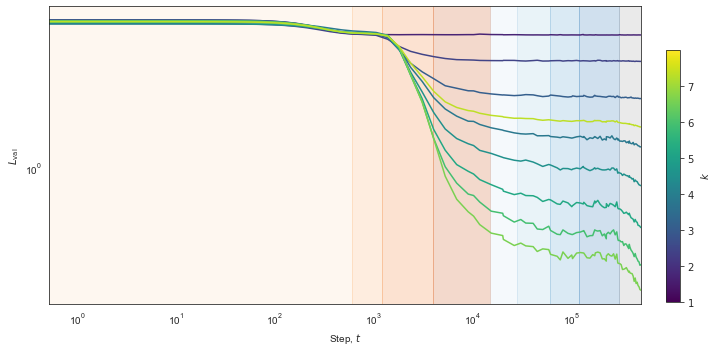

In [221]:
from matplotlib import colors as mcolors

LINE_PALETTE="viridis"
ALPHA=1

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.lineplot(data=losses_over_time, x="step", y="loss", hue="token", palette=LINE_PALETTE, alpha=ALPHA, ax=ax)

ax.set_yscale('log')
ax.set_xscale("log")
ax.set_xlabel("Step, $t$")
ax.set_ylabel("$L_\mathrm{val}$")
ax.legend().remove()

plot_transitions(ax, TRANSITIONS, limit=True) #, alpha=0.25)

cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  # Adjust as necessary for position and size

# custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", LINE_PALETTE)

sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=1, vmax=8), )
sm._A = []  # Dummy array for the ScalarMappable. 
cbar = fig.colorbar(sm, cax=cbar_ax)

tick_positions = range(1, len(LINE_PALETTE)+1)  # Positions for each color
tick_labels = [f"${i}$" for i in range(1, len(LINE_PALETTE) + 1)] # Replace with your labels
cbar.set_ticks(tick_positions)
cbar.set_ticklabels(tick_labels)
cbar.set_label("$k$")

plt.tight_layout(rect=[0, 0, 0.91, 1])  # Adjust layout to make room for colorbar


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


/Users/Jesse/Projects/icl/icl/figures/colors.py:70: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(min_step, max_step)
<ipython-input-222-cbaaac0716fd>:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 1])  # Adjust layout to make room for colorbar


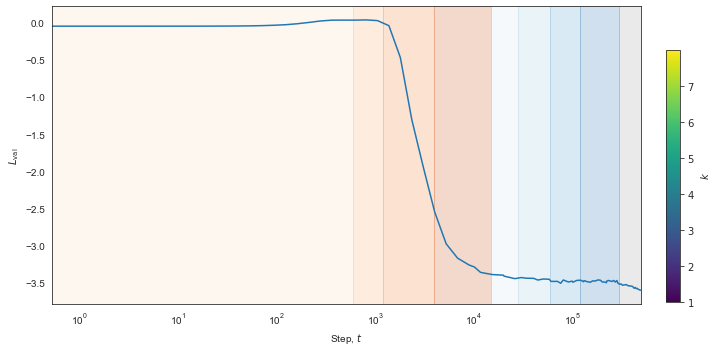

In [222]:
from matplotlib import colors as mcolors

LINE_PALETTE="viridis"
ALPHA=1

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

icl_score = losses_over_time.loc[losses_over_time.token == 8, "loss"].values - losses_over_time.loc[losses_over_time.token == 1, "loss"].values
sns.lineplot(x=steps, y=icl_score, alpha=ALPHA, ax=ax)
    
# ax.set_yscale('log')
ax.set_xscale("log")
ax.set_xlabel("Step, $t$")
ax.set_ylabel("$L_\mathrm{val}$")
ax.legend().remove()

plot_transitions(ax, TRANSITIONS, limit=True) #, alpha=0.25)

cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  # Adjust as necessary for position and size

# custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", LINE_PALETTE)

sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=1, vmax=8), )
sm._A = []  # Dummy array for the ScalarMappable. 
cbar = fig.colorbar(sm, cax=cbar_ax)

tick_positions = range(1, len(LINE_PALETTE)+1)  # Positions for each color
tick_labels = [f"${i}$" for i in range(1, len(LINE_PALETTE) + 1)] # Replace with your labels
cbar.set_ticks(tick_positions)
cbar.set_ticklabels(tick_labels)
cbar.set_label("$k$")

plt.tight_layout(rect=[0, 0, 0.91, 1])  # Adjust layout to make room for colorbar


## Behavioral Essential Dynamics

In [441]:
# Do the PCAs again. 
from typing import Dict, Iterable, Tuple
from sklearn.decomposition import PCA
from collections import defaultdict
from devinterp.mechinterp.hooks import hook
import numpy as np
from icl.analysis.utils import map_evals_over_checkpoints, get_unique_run
from icl.train import Run
from devinfra.utils.tensors import convert_tensor, ReturnTensor
from matplotlib import colors as mcolors


def extract_activations_over_checkpoints(models: Iterable[nn.Module], xs, ys, *paths, return_type: ReturnTensor="np"):
    def eval_activations(model):
        model.to(DEVICE)
        xs.to(model.device)
        ys.to(model.device)
        hooked_model = hook(model, *paths)
        outputs, activations = hooked_model.run_with_cache(xs, ys)
        activations[""] = outputs
        return {k: convert_tensor(v, return_type) for k, v in activations.items() if (k in paths or k == "") and v is not None}
    
    for model in models:
        yield eval_activations(model)


def get_vectorized_activations_trace(models: Iterable[nn.Module], xs, ys, *paths, normalize=False):
    evals: Dict[str, list] = defaultdict(list)
    
    for activations in extract_activations_over_checkpoints(models, xs, ys, *paths):
        for path, activation in activations.items():
            if normalize:
                activation = activation / np.linalg.norm(activation)

            evals[path].append(activation)

    return {
        k: np.array(v).reshape(len(v), -1) for k, v in evals.items()
    }

def get_pca_activations_trace(models: Iterable[nn.Module], xs, ys, *paths, num_components=3, normalize=False) -> Dict[str, Tuple[PCA, np.ndarray]]:
    results = {}

    for path, activations in get_vectorized_activations_trace(models, xs, ys, *paths, normalize=normalize).items():
        pca = PCA(n_components=num_components)
        activations_reduced = pca.fit_transform(activations)
        results[path] = pca, activations_reduced

    return results


tab10 = plt.cm.get_cmap('tab10', 10)  # Get the tab10 colormap
colors = tab10.colors[:len(TRANSITIONS)]  # Get the first 6 colors 
# Add an extra gray to this np array for extra colors
colors = np.vstack((colors, np.array([0.8, 0.8, 0.8, 1.0])))

# Create a new colormap from the extracted colors
custom_cmap = mcolors.ListedColormap(colors)

# plot_multiple_slices(steps, demo_logits_reduced_3, demo_logits_pca_3, title=demo.config.to_latex(), connect_dots=True)
train_xs_1, train_ys_1 = pretrain_dist_noiseless.get_batch(8, 1024)

traces = get_pca_activations_trace(
    models,
    train_xs_1, 
    train_ys_1, 
    "token_sequence_transformer",
    # "token_sequence_transformer.blocks.1",
    # "token_sequence_transformer.token_embedding",
    num_components=10,
    normalize=False
) 

# traces_small = get_pca_activations_trace(
#     models,
#     train_xs_1[:1024], 
#     train_ys_1[:1024], 
#     "",
#     "token_sequence_transformer.blocks.1",
#     # "token_sequence_transformer.token_embedding",
#     num_components=3,
#     normalize=False
# ) 

pca_outputs, logits_outputs = traces[""]
pca_logits, logits_reduced = traces["token_sequence_transformer"]
# pca_internal, activations_reduced = traces_small["token_sequence_transformer.blocks.1"]

traces_normalized = get_pca_activations_trace(
    models,
    train_xs_1, 
    train_ys_1, 
    "token_sequence_transformer",
    # "token_sequence_transformer.blocks.1",
    # "token_sequence_transformer.token_embedding",
    num_components=10,
    normalize=True
) 

# traces_small_normalized = get_pca_activations_trace(
#     models,
#     train_xs_1[:1024], 
#     train_ys_1[:1024], 
#     # "token_sequence_transformer",
#     "token_sequence_transformer.blocks.1",
#     # "token_sequence_transformer.token_embedding",
#     num_components=3,
#     normalize=True
# ) 

pca_outputs_normalized, activations_outputs_normalized = traces_normalized[""]
pca_internal_normalized, activations_reduced_normalized = traces_normalized["token_sequence_transformer"]
# pca_internal, activations_reduced = traces_small["token_sequence_transformer.blocks.1"]

<ipython-input-441-c51b2bb1e7a0>:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  tab10 = plt.cm.get_cmap('tab10', 10)  # Get the tab10 colormap


In [468]:
import matplotlib.pyplot as plt
import os
from typing import Optional

def get_transition_indices(steps, transitions):
    transition_indices = []
    for step in steps:
        # Find the index of the transition that the current step falls into
        index = next((i for i, transition in enumerate(transitions) if transition[0] <= step < transition[1]), None)
        transition_indices.append(index if index is not None else -1)

    return transition_indices

def get_nearest_step(step):
    idx = np.argmin(np.abs(np.array(steps) - step))
    return steps[idx]

def plot_explained_variance(pca, title="Explained Variance", ax: Optional[plt.Axes] = None, num_pca_components=None):
    num_pca_components = num_pca_components or len(pca.explained_variance_ratio_)

    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 8))

    ax.bar(range(num_pca_components), pca.explained_variance_ratio_[:num_pca_components])

    for i, ratio in enumerate(pca.explained_variance_ratio_[:num_pca_components]):
        ax.text(i, ratio, f"{ratio:.2f}", fontsize=12, ha='center', va='bottom')

    ax.set_title(title)
    ax.set_xlabel('PC')
    ax.set_ylabel('Explained Variance')

    ax.set_xticks(range(num_pca_components), range(1, num_pca_components + 1))


def plot_multiple_slices(steps, samples, pca, transitions, highlighted_steps=None, connect_dots=False, palette='tab10', alpha=0.8, save=False, line_color="auto"):
    transition_idxs = get_transition_indices(steps, transitions)
    # transition_idxs = [(0 if i != 4 else 1) for i in transition_idxs]

    # for i in range(1, 5):
    #     transition_idxs[-i] = 10  

    if highlighted_steps is None:
        highlighted_steps = list(map(get_nearest_step, [t[0] for t in transitions][1:]))

    num_pca_components = samples.shape[-1]
    
    # Create a single row of subplots
    num_pca_combos = (num_pca_components * (num_pca_components-1)) // 2
    
    fig, axes = plt.subplots(1, num_pca_combos + 1, figsize=(20, 4))
    # fig.suptitle(title)

    # Ensure ax is iterable by converting to a list if there's only one subplot
    if num_pca_components == 2:
        axes = [axes]

    I = 0
    for i in range(1, num_pca_components):
        for j in range(i):

            if connect_dots:
                axes[I].plot(samples[:, i], samples[:, j], c='black', alpha=0.2)

            # sc = axes[I].scatter(samples[:, i], samples[:, j], c=transition_idxs, cmap=cmap, s=50, alpha=alpha)
            sns.scatterplot(x=samples[:, i], y=samples[:, j], hue=transition_idxs, palette=palette, s=50, alpha=alpha, ax=axes[I], legend=False)
            axes[I].set_xlabel(f'PC {i}')
            axes[I].set_ylabel(f'PC {j}')
            axes[I].set_title(f'PC {i} vs PC {j}')

            # Label some points
            total_samples = len(samples)
            for step in highlighted_steps:
                k = steps.index(step)  # Find the index of the highlighted step
                axes[I].text(samples[k, i], samples[k, j], str(step), fontsize=8, ha='right', va='bottom', alpha=0.8)

            I += 1

    plot_explained_variance(pca, ax=axes[-1], num_pca_components=num_pca_components)
    # for I in range( num_pca_combos):
    #     axes[I].axis('off')
            
    # Colorbar for the last plot
    # cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust as necessary
        # plt.colorbar(sc, cax=cbar_ax, label='Milestones')

    cmap = sns.palettes.color_palette(palette, n_colors=len(transitions) + 1)

    # Plot the legend on the first subplot on the left
    legend_ax = axes[0]
    scatter_proxy = [plt.Line2D([0], [0], linestyle='none', marker='o', alpha=alpha, color=cmap[i]) for i in range(len(transitions))]
    legend_labels = [label for _, _, label in transitions]
    legend_ax.legend(scatter_proxy, legend_labels, loc='center', ncol=1, frameon=False, bbox_to_anchor=(-0.5, 0.5), title='Developmental Stages')
    # legend_ax.set_title()

    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the right side to make room for the colorbar

    if save:
        parent_dir = os.path.dirname(save)
        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)
        plt.savefig(save)


    fig.set_facecolor('white')
    
# Usage of the function
# Call the function with your data and the list of highlighted steps
# plot_multiple_slices(steps, samples, pca, highlighted_steps=[100, 1000, 10000], title="Your Title", num_points_to_label=10, save="path/to/save.png", connect_dots=True)

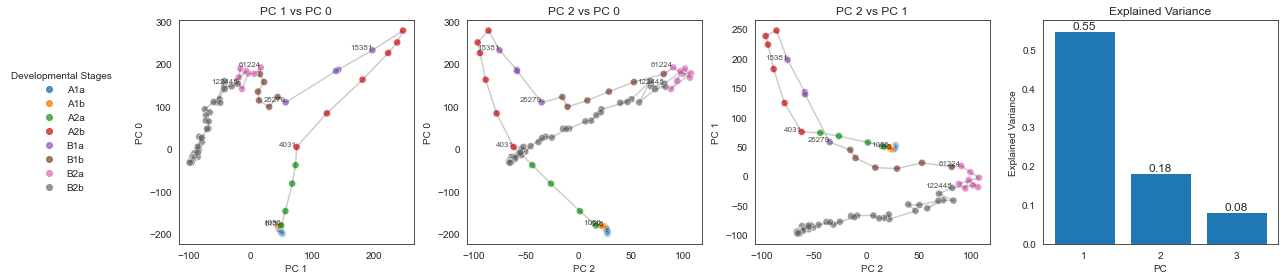

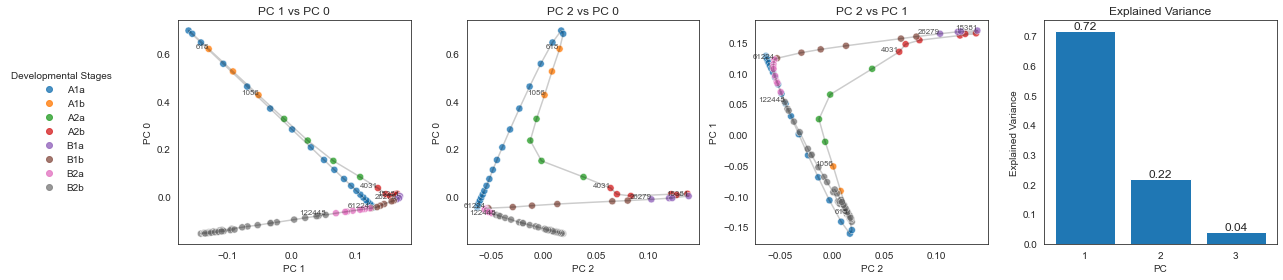

In [470]:
plot_multiple_slices(
    steps, 
    logits_reduced[:, :3], 
    pca_logits, 
    TRANSITIONS,
    connect_dots=True, 
    save=None,
    # cmap=transitions_cmap
)
plt.show()

plot_multiple_slices(
    steps, 
    exp_avg_grads_reduced[:, :3], 
    pca_1, 
    TRANSITIONS,
    connect_dots=True, 
    save=None,
    # cmap=transitions_cmap
)

plt.show()


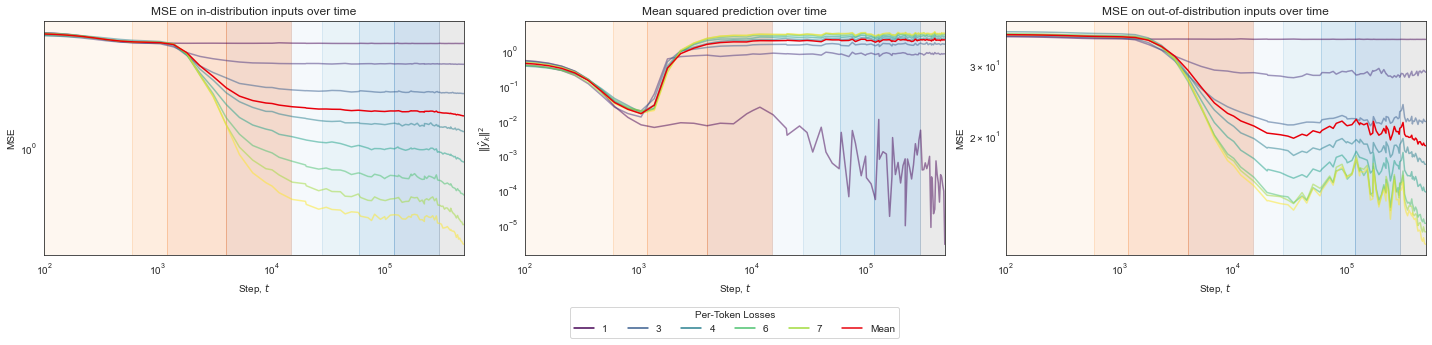

In [227]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

token_losses_over_time = losses_over_time.loc[losses_over_time.token != "$\overline{\hat y}$"]
mean_losses_over_time = losses_over_time.loc[losses_over_time.token == "$\overline{\hat y}$"]

sns.lineplot(data=token_losses_over_time, x="step", y=f"loss", hue="token", palette="viridis", ax=axes[0], alpha=0.5)
sns.lineplot(data=token_losses_over_time, x="step", y=f"loss_0", hue="token", palette="viridis", ax=axes[1], alpha=0.5)
sns.lineplot(data=token_losses_over_time, x="step", y=f"ood_loss", hue="token", palette="viridis", ax=axes[2], alpha=0.5)

sns.lineplot(data=mean_losses_over_time, x="step", y="loss", label="Mean", ax=axes[0], color=BRED)
sns.lineplot(data=mean_losses_over_time, x="step", y=f"loss_0", label="Mean", ax=axes[1], color=BRED)
sns.lineplot(data=mean_losses_over_time, x="step", y="ood_loss", label="Mean", ax=axes[2], color=BRED)

for ax in axes:
    ax.set_xscale("log")
    ax.set_xlabel("Step, $t$")
    ax.set_yscale('log')
    legend = ax.legend()
    legend.remove()
    ax.set_xlim(100, 500_000)

legend = axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=6)
legend.set_title("Per-Token Losses")

# Move legend to be likee fig.legend(patch_list, milestone_labels, loc='upper center', bbox_to_anchor=(0.5, -0.025), ncol=len(TRANSITIONS))

axes[0].set_title("MSE on in-distribution inputs over time")
axes[0].set_ylabel("MSE")

axes[1].set_title("Mean squared prediction over time")
axes[1].set_ylabel("$\|\hat y_k\|^2$")

axes[2].set_title("MSE on out-of-distribution inputs over time")
axes[2].set_ylabel("MSE")

plot_transitions(axes, TRANSITIONS)

for ax in axes:
    ax.set_xscale('log')

plt.tight_layout()
# Add color bar on the far right

fig.set_facecolor('white')

# Geometric Indicators

## Gradients

In [ ]:
from torch.nn import functional as F

gradient_stats = []

xs, ys = run.evaluator.pretrain_xs, run.evaluator.pretrain_ys
xs, ys = xs.to(DEVICE), ys.to(DEVICE)


for step, model in zip(steps, models):
    model.to(DEVICE)
    model.zero_grad()

    yhats = model(xs, ys)

    loss = F.mse_loss(yhats, ys)
    loss.backward()

    for n, p in model.named_parameters():

        if p.grad is None:
            continue

        grad_sq_mean = (p.grad ** 2).mean().item()
        grad_sq_std = (p.grad ** 2).std().item()

        gradient_stats.append({
            "step": step,
            "layer": n,
            "grad/norm": grad_sq_mean ** 0.5,
            "grad_sq/mean": grad_sq_mean,
            "grad_sq/std": grad_sq_std,
            "numel": p.numel(),
            "loss": loss.item(),
        })          

        p.grad = None 

gradient_stats = pd.DataFrame(gradient_stats)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))

avg_gradients = gradient_stats.groupby(['step']).mean()

grad_norm_thresholded = gradient_stats['grad/norm'].values + 0.00001

sns.lineplot(data=gradient_stats, x='step', y=grad_norm_thresholded, hue="layer", ax=ax, legend=False, alpha=0.5)
sns.lineplot(data=avg_gradients, x='step', y='grad/norm', ax=ax, legend=False, color=BRED)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Step, $t$")
ax.set_ylabel("Gradient norm, $\|w_t\|$")

_ = plot_transitions(ax, TRANSITIONS, limit=True)


In [ ]:
# Let's look at the optimizer state

names = [n for n, _ in run.model.named_parameters()]

optimizer_stats = []

for step, optimizer_state_dict in zip(steps, optimizer_state_dicts):
    for layer, g in optimizer_state_dict["state"].items():
        optimizer_stats.append({
            "step": step,
            "layer": layer,
            "layer_name": list(model.state_dict().keys())[layer],
            "exp_avg_sq_norm": g["exp_avg_sq"].norm().item() + 0.0000001
        })

optimizer_stats = pd.DataFrame(optimizer_stats)
avg_optimizer_stats = optimizer_stats.groupby('step').mean()

fig, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(data=optimizer_stats, x="step", y="exp_avg_sq_norm", hue="layer", palette="viridis", ax=ax, alpha=0.5)
sns.lineplot(data=avg_optimizer_stats, x="step", y="exp_avg_sq_norm", palette="viridis", ax=ax, color=BRED)
ax.set_ylabel("Gradient Norm")
ax.set_xlabel("Step")
ax.set_title("Gradient Norms by Layer and Step")
ax.legend().remove()

plot_transitions(ax, TRANSITIONS, limit=True)

ax.set_yscale("log")
ax.set_xscale("log")

In [ ]:
# I want to see in what order the layers reach "zero"
# 1. Figure out the earliest step for each layer where exp_avg_sq_norm < 1e-5
# 2. Order by this earliest step
# 3. List the names

threshold = 3e-7

# Find the earliest step where exp_avg_sq_norm < threshold for each layer
earliest_zero_step = optimizer_stats[optimizer_stats['exp_avg_sq_norm'] < threshold] \
    .groupby('layer_name') \
    .agg(earliest_step=('step', 'min'))

# Now, sort the layers by the earliest step where their norm goes below the threshold
sorted_layers_by_earliest_zero_step = earliest_zero_step.sort_values(by='earliest_step')
sorted_layers_by_earliest_zero_step

## Gradient essential dynamics

In [ ]:
from torch.nn import functional as F
from sklearn.manifold import TSNE

try:
    del gradients_over_time
    del gradients_reduced
    del gradients_reduced_normalized
except NameError:
    pass

PERPLEXITY = 15

for layer_name in [
    "token_sequence_transformer.token_embedding",
    "token_sequence_transformer.unembedding.0",
    "token_sequence_transformer.blocks.0.compute.0",
    "token_sequence_transformer.blocks.0.compute.2",
    "token_sequence_transformer.blocks.1.compute.0",
    "token_sequence_transformer.blocks.1.compute.2"
]:
    layer_path = layer_name.split(".")
    last_state_dict = models[-1].state_dict()
    num_params = 0
    
    for subset in ("weight", "bias"):
        subset_full_name = layer_name + "." + subset
        if subset_full_name in last_state_dict:
            num_params += models[-1].state_dict()[subset_full_name].numel()
            
    gradients_over_time = np.zeros((len(steps), num_params))

    def get_params(model, layer_path):
        m = model
        for part in layer_path:
            m = getattr(m, part)
        
        return m

    for i, model in enumerate(models):
        # model.train()
        model.to(DEVICE)
        model.zero_grad()

        yhats = model(xs, ys)

        loss = F.mse_loss(yhats, ys)
        loss.backward()

        layer = get_params(model, layer_path)

        n = 0
        for subset in ("weight", "bias"):
            if layer and hasattr(layer, subset):
                param = getattr(layer, subset)
                if param is None:
                    continue

                numel = param.numel()
                gradients_over_time[i, n:n+numel] = param.grad.flatten().cpu().numpy()
                n += numel

    pca = PCA(n_components=50)
    gradients_reduced = pca.fit_transform(gradients_over_time)

    norms = np.linalg.norm(gradients_over_time, axis=1, keepdims=True)
    norms[norms == 0] = 1

    gradients_reduced_normalized = pca.fit_transform(gradients_over_time / norms)

    plot_multiple_slices(
        steps, 
        gradients_reduced[:, :3], 
        pca, 
        highlight_steps,
        transitions_of_steps,
        connect_dots=True, 
        save=None,
    )

    plt.show()

    tsne = TSNE(n_components=2, perplexity=PERPLEXITY, n_iter=1000, random_state=0)
    gradients_tsne = tsne.fit_transform(gradients_reduced)

    plt.scatter(gradients_tsne[:, 0], gradients_tsne[:, 1], c=transitions_of_steps, cmap=custom_cmap, s=50, alpha=0.6)
    plt.show()

    tsne_normalized = TSNE(n_components=2, perplexity=PERPLEXITY, n_iter=1000, random_state=0)
    gradients_tsne_normalized = tsne.fit_transform(gradients_reduced_normalized)

    plt.scatter(gradients_tsne_normalized[:, 0], gradients_tsne_normalized[:, 1], c=transitions_of_steps, cmap=custom_cmap, s=50, alpha=0.6)
    plt.show()

## Gradient clustering

In [ ]:
from torch.nn import functional as F
from sklearn.manifold import TSNE

try:
    del gradients_over_time
    del gradients_reduced
    del gradients_reduced_normalized
except NameError:
    pass

PERPLEXITY = 10

def get_all_params_as_array(model):
    return np.concatenate([p.cpu().numpy().flatten() for p in model.parameters()])


def get_all_gradients_as_array(model):
    return np.concatenate([p.grad.cpu().numpy().flatten() for p in model.parameters() if p.grad is not None])

gradients_over_time = []
gradients_normalized_over_time = []

for i, model in enumerate(models):
    # model.train()
    model.to(DEVICE)
    model.zero_grad()

    yhats = model(xs, ys)

    loss = F.mse_loss(yhats, ys)
    loss.backward()

    layer = get_params(model, layer_path)

    gradients = get_all_gradients_as_array(model)
    gradients_over_time.append(gradients)
    gradients_normalized_over_time.append(gradients / np.linalg.norm(gradients))

gradients_over_time = np.array(gradients_over_time)
gradients_normalized_over_time = np.array(gradients_normalized_over_time)

pca_1 = PCA(n_components=50)
gradients_reduced = pca_1.fit_transform(gradients_over_time)

pca_2 = PCA(n_components=50)
gradients_reduced_normalized = pca_2.fit_transform(gradients_normalized_over_time)

plot_multiple_slices(
    steps, 
    gradients_reduced[:, :3], 
    pca_1, 
transitions,

    transitions_of_steps,
    connect_dots=True, 
    save=None,
)

plot_multiple_slices(
    steps, 
    gradients_reduced_normalized[:, :3], 
    pca_2, 
transitions,

    transitions_of_steps,
    connect_dots=True, 
    save=None,
)

plt.show()


print("Full gradients")
print("Unnormalized")

tsne = TSNE(n_components=2, perplexity=PERPLEXITY, n_iter=1000, random_state=0)
gradients_tsne = tsne.fit_transform(gradients_reduced)

plt.scatter(gradients_tsne[:, 0], gradients_tsne[:, 1], c=transitions_of_steps, cmap=custom_cmap, s=50, alpha=0.6)
plt.show()

print("Normalized")

tsne_normalized = TSNE(n_components=2, perplexity=PERPLEXITY, n_iter=1000, random_state=0)
gradients_tsne_normalized = tsne.fit_transform(gradients_reduced_normalized)

plt.scatter(gradients_tsne_normalized[:, 0], gradients_tsne_normalized[:, 1], c=transitions_of_steps, cmap=custom_cmap, s=50, alpha=0.6)
plt.show()

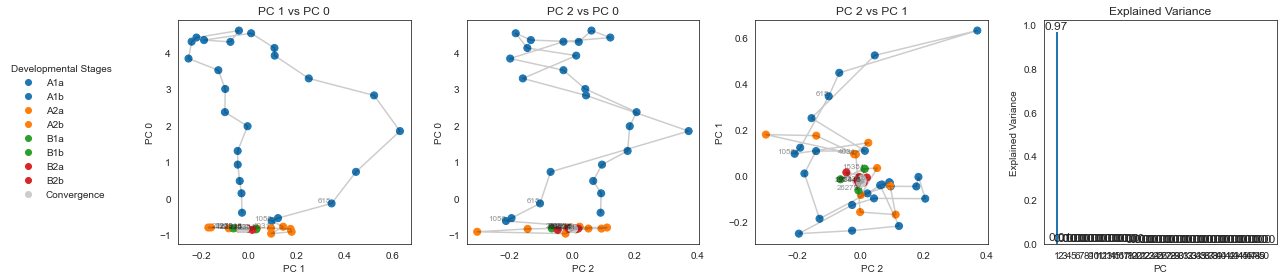

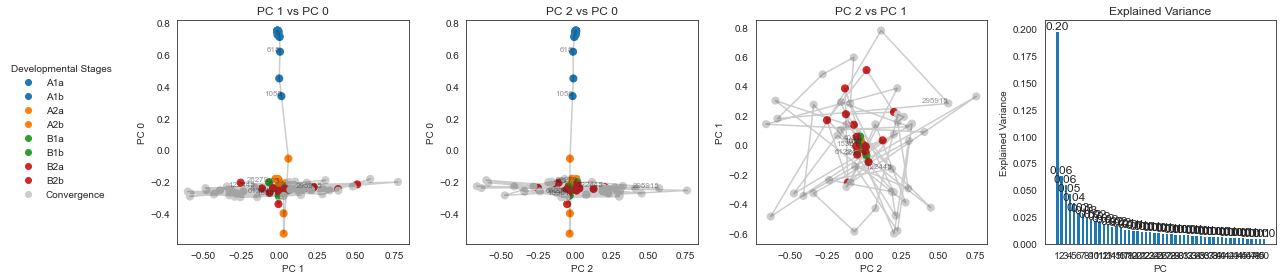

Exponentially averaged gradients
Unnormalized


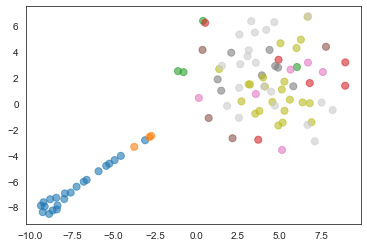

Normalized


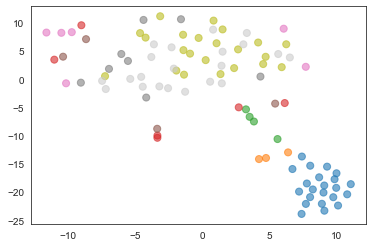

In [235]:
from torch.nn import functional as F
from sklearn.manifold import TSNE

try:
    del exp_avg_grads_over_time
    del exp_avg_grads_reduced
    del exp_avg_grads_reduced_normalized
except NameError:
    pass

PERPLEXITY = 15

exp_avg_grads_over_time = []
exp_avg_grads_normalized_over_time = []

def get_exp_avg_sq_grads(optimizer_state_dict):
    return np.concatenate([g["exp_avg_sq"].cpu().numpy().flatten() for g in optimizer_state_dict["state"].values()])

def get_exp_avg_grads(optimizer_state_dict):
    return np.concatenate([g["exp_avg"].cpu().numpy().flatten() for g in optimizer_state_dict["state"].values()])


for i, opt_state in enumerate(optimizer_state_dicts):
    # model.train()
    exp_avg_grads = get_exp_avg_grads(opt_state)
    exp_avg_grads_over_time.append(exp_avg_grads)
    exp_avg_grads_normalized_over_time.append(exp_avg_grads / np.linalg.norm(exp_avg_grads))

exp_avg_grads_over_time = np.array(exp_avg_grads_over_time)
exp_avg_grads_normalized_over_time = np.array(exp_avg_grads_normalized_over_time)


pca_1 = PCA(n_components=50)
exp_avg_grads_reduced = pca_1.fit_transform(exp_avg_grads_over_time)

pca_2 = PCA(n_components=50)
exp_avg_grads_reduced_normalized = pca_2.fit_transform(exp_avg_grads_normalized_over_time)

plot_multiple_slices(
    steps, 
    exp_avg_grads_reduced[:, :3], 
    pca_1, 
transitions,

    transitions_of_steps,
    connect_dots=True, 
    save=None,
)

plot_multiple_slices(
    steps, 
    exp_avg_grads_reduced_normalized[:, :3], 
    pca_2, 
transitions,

    transitions_of_steps,
    connect_dots=True, 
    save=None,
)

plt.show()

print("Exponentially averaged gradients")
print("Unnormalized")

tsne = TSNE(n_components=2, perplexity=PERPLEXITY, n_iter=1000, random_state=0)
exp_avg_grads_tsne = tsne.fit_transform(exp_avg_grads_reduced)

plt.scatter(exp_avg_grads_tsne[:, 0], exp_avg_grads_tsne[:, 1], c=transitions_of_steps, cmap=custom_cmap, s=50, alpha=0.6)
plt.show()

print("Normalized")

tsne_normalized = TSNE(n_components=2, perplexity=PERPLEXITY, n_iter=1000, random_state=0)
exp_avg_grads_tsne_normalized = tsne.fit_transform(exp_avg_grads_reduced_normalized)

plt.scatter(exp_avg_grads_tsne_normalized[:, 0], exp_avg_grads_tsne_normalized[:, 1], c=transitions_of_steps, cmap=custom_cmap, s=50, alpha=0.6)
plt.show()

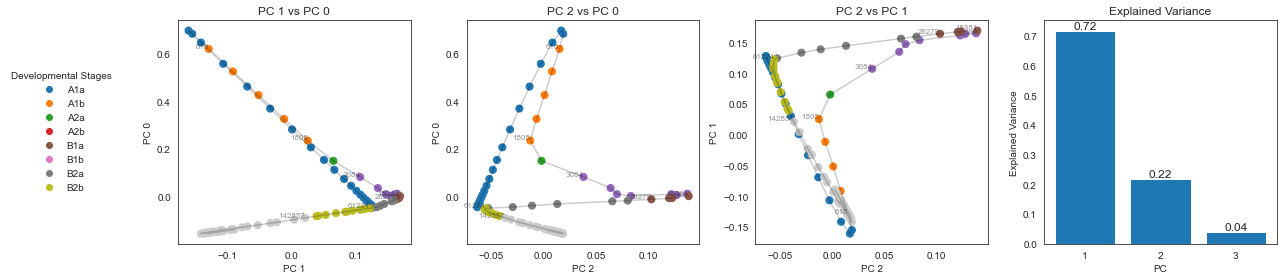

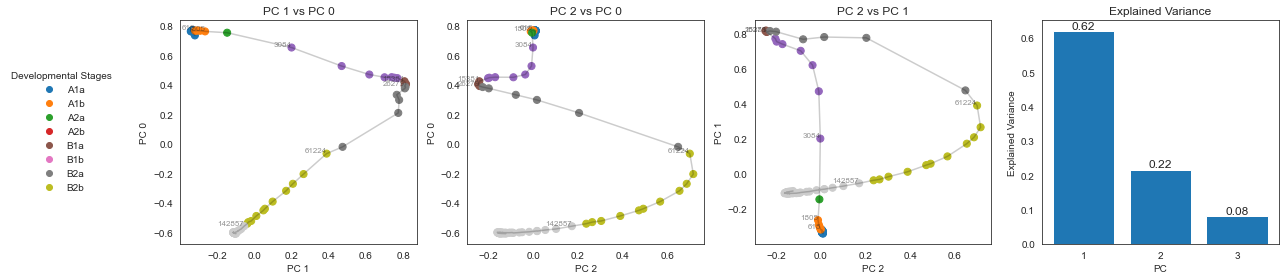

Exponentially averaged square gradients
Unnormalized


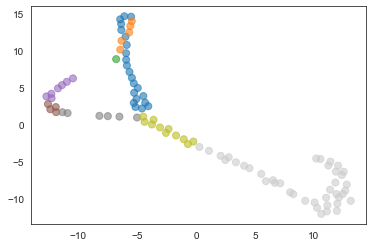

Normalized


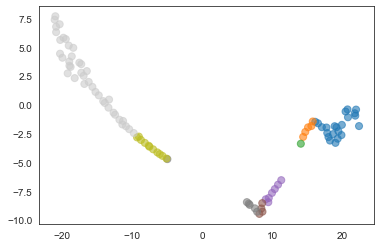

In [376]:
from torch.nn import functional as F
from sklearn.manifold import TSNE

try:
    del exp_avg_grads_over_time
    del exp_avg_grads_reduced
    del exp_avg_grads_reduced_normalized
except NameError:
    pass

PERPLEXITY = 15

exp_avg_grads_over_time = []
exp_avg_grads_normalized_over_time = []

def get_exp_avg_sq_grads(optimizer_state_dict):
    return np.concatenate([g["exp_avg_sq"].cpu().numpy().flatten() for g in optimizer_state_dict["state"].values()])

def get_exp_avg_grads(optimizer_state_dict):
    return np.concatenate([g["exp_avg"].cpu().numpy().flatten() for g in optimizer_state_dict["state"].values()])


for i, opt_state in enumerate(optimizer_state_dicts):
    # model.train()
    exp_avg_grads = get_exp_avg_sq_grads(opt_state)
    exp_avg_grads_over_time.append(exp_avg_grads)
    exp_avg_grads_normalized_over_time.append(exp_avg_grads / np.linalg.norm(exp_avg_grads))

exp_avg_grads_over_time = np.array(exp_avg_grads_over_time)
exp_avg_grads_normalized_over_time = np.array(exp_avg_grads_normalized_over_time)

pca_1 = PCA(n_components=50)
exp_avg_grads_reduced = pca_1.fit_transform(exp_avg_grads_over_time)

pca_2 = PCA(n_components=50)
exp_avg_grads_reduced_normalized = pca_2.fit_transform(exp_avg_grads_normalized_over_time)

plot_multiple_slices(
    steps, 
    exp_avg_grads_reduced[:, :3], 
    pca_1, 
transitions,

    transitions_of_steps,
    connect_dots=True, 
    save=None,
    # cmap=transitions_cmap
)

plot_multiple_slices(
    steps, 
    exp_avg_grads_reduced_normalized[:, :3], 
    pca_2, 
transitions,

    transitions_of_steps,
    connect_dots=True, 
    save=None,
    # cmap=transitions_cmap,
)

plt.show()

print("Exponentially averaged square gradients")
print("Unnormalized")

tsne = TSNE(n_components=2, perplexity=PERPLEXITY, n_iter=1000, random_state=0)
exp_avg_grads_tsne = tsne.fit_transform(exp_avg_grads_reduced)

plt.scatter(exp_avg_grads_tsne[:, 0], exp_avg_grads_tsne[:, 1], c=transitions_of_steps, cmap=custom_cmap, s=50, alpha=0.6)
plt.show()

print("Normalized")
tsne_normalized = TSNE(n_components=2, perplexity=PERPLEXITY, n_iter=1000, random_state=0)
exp_avg_grads_tsne_normalized = tsne.fit_transform(exp_avg_grads_reduced_normalized)

plt.scatter(exp_avg_grads_tsne_normalized[:, 0], exp_avg_grads_tsne_normalized[:, 1], c=transitions_of_steps, cmap=custom_cmap, s=50, alpha=0.6)
plt.show()

In [ ]:

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=0)
gradients_tsne = tsne.fit_transform(gradients_reduced)

plt.scatter(gradients_tsne[:, 0], gradients_tsne[:, 1], c=transitions_of_steps, cmap=custom_cmap, s=50, alpha=0.6)

## SGLD PCAs

In [ ]:
from pprint import pp
import sys

from icl.analysis.slt import ExpectedBatchLossEstimator
from icl.analysis.weights import WeightsTrace 
del sys.modules['icl.analysis.sample']
del sys.modules['icl.analysis.slt']
del sys.modules['icl.analysis.estimators']

import yaml
from icl.analysis.sample import SamplerConfig

os.environ.setdefault('PYTORCH_ENABLE_MPS_FALLBACK', '1')

CORES = 1
NUM_CHAINS = 25
NUM_DRAWS = 1000
NUM_SAMPLES = 1024
DATASET_SIZE = 2 ** 14

sampler_config: SamplerConfig = SamplerConfig(
    num_chains=NUM_CHAINS,
    num_draws=NUM_DRAWS,
    sampling_method='sgld',
    grad_batch_origin='eval-dataset',
    grad_batch_size=NUM_SAMPLES,
    noise_scale=5e-3,    
    localization_scale=5e-2,
    gradient_scale=1e-5 * 1024. / (2 * np.log(1024)), 
    # noise_scale=5e-4,    
    # localization_scale=1e-1,
    # gradient_scale=1e-6 * 1024. / (2 * np.log(1024)), 
    # eval_method='fixed-minibatch',
    eval_method='grad-minibatch',
    eval_metrics=['likelihood-derived', 'batch-loss', 'weights'],
    # eval_batch_size=8192,
    eval_dataset_size=DATASET_SIZE,
    device='cpu',
    cores=CORES,
    eval_loss_fn='mse',
    eval_online=True
)

print(yaml.dump(sampler_config.model_dump()))

run.model = models[-1]
run.model.to('cpu')
# log_fn = lambda data, step=None: print(f"Step: {step}\n", yaml.dump(data))
sampler = sampler_config.to_sampler(run, log_fn=None)
print("INIT LOSS", sampler.init_loss)

results = sampler.eval(run.model)

pp(sampler.callbacks[0].estimate())

In [ ]:
llc_callback = sampler.callbacks[0]
sgld_estimates_df = llc_callback.estimates()

sgld_estimates_df

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

batch_losses = sampler.batch_loss.estimates()
batch_losses['mean'] = [float(x) for x in batch_losses['mean']]

#llc_callback.expected_loss_estimator.
sns.lineplot(data=batch_losses, x="draw", y="mean", hue="chain", palette="gray", ax=ax, alpha=0.5)

twin_ax = ax.twinx()
sns.lineplot(data=sgld_estimates_df, x="draw", y="llc/mean", ax=twin_ax, alpha=0.5, color=PRIMARY)

ax.set_ylabel(r"Batch Loss. $L^{(\tau)}_m$")
twin_ax.set_ylabel(r"LLC, $\hat\lambda_\tau$", color=PRIMARY)
for label in twin_ax.get_yticklabels():
    label.set_color(PRIMARY)

ax.set_xlabel(r"Draw, $\tau$")
ax.legend().remove()


In [ ]:
init_weights_np = np.concatenate([p.view(-1).detach().cpu().numpy() for p in run.model.parameters()])

weights_np = sampler.callbacks[-1].weights.detach().cpu().numpy()[:, :, :]
# del sampler.callbacks[-1].weights

weights_flat = weights_np.reshape(-1, weights_np.shape[-1]) - init_weights_np

from sklearn.decomposition import PCA
pca = PCA(n_components=50)
weights_reduced = pca.fit_transform(weights_flat)

# from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=0)
weights_tsne = tsne.fit_transform(weights_reduced)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_explained_variance(pca, ax=ax)

In [ ]:
init_weights_np = np.concatenate([p.view(-1).detach().cpu().numpy() for p in run.model.parameters()])

weights_np = sampler.callbacks[-1].weights.detach().cpu().numpy()[:, :, :]
# del sampler.callbacks[-1].weights

weights_flat = weights_np.reshape(-1, weights_np.shape[-1]) - init_weights_np

from sklearn.decomposition import PCA
pca = PCA(n_components=50)
weights_reduced = pca.fit_transform(weights_flat)

# from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=0)
weights_tsne = tsne.fit_transform(weights_reduced)

In [ ]:
for chain in range(NUM_CHAINS):
    _weights = weights_tsne[chain * NUM_DRAWS:(chain + 1) * NUM_DRAWS] 
    sns.scatterplot(x=_weights[:, 0], y=_weights[:, 1], s=50, alpha=0.6)

In [ ]:
import itertools

def plot_weights_trace_fn(model, deltas, xs, ys, device='cpu', num_components=3, num_points=10):
    model.to(device)
    xs.to(device)
    ys.to(device)

    num_chains = deltas.shape[0]
    num_draws = deltas.shape[1]


    pca = PCA(n_components=num_components)

    weights_reduced = pca.fit_transform(deltas.reshape(num_chains * num_draws, -1))

    def get_pc_landscape(pca, fn, pc1, pc2, pc1_lim: Tuple[int, int], pc2_lim: Tuple[int, int], num_points=100, ax=None):
        xx, yy = np.meshgrid(np.linspace(*pc1_lim, num_points), np.linspace(*pc2_lim, num_points))

        # Compute function values for the grid
        Z = np.zeros(xx.shape)
        for i in tqdm.tqdm(range(xx.shape[0]), "Iterating over rows"):
            for j in range(xx.shape[1]):
                u = xx[i, j] * pc1 + yy[i, j] * pc2
                Z[i, j] = fn(u)

        # Plot the density map
        Z = (Z - Z.min()) / (Z.max() - Z.min()) # rescale
        Z = np.log(1e-3 + Z)
        
        im = ax.imshow(Z, interpolation='bilinear', origin='lower',
            extent=(*pc1_lim, *pc2_lim), cmap='Blues', alpha=1., aspect='auto')
        
        return Z

    def weights_to_model(weights):
        m = deepcopy(model)
        m.to(device)

        i = 0
        for n, p in m.named_parameters():
            p.data += torch.from_numpy(weights[i:i+p.numel()]).view(p.shape).to(device)
            i += p.numel()
        
        return m


    def weights_to_loss(weights):
        m = weights_to_model(weights)
        yhats = m(xs, ys)
        return F.mse_loss(yhats, ys).item()

    xs.to(device)
    ys.to(device)

    pc_combos = list(itertools.combinations(range(num_components), 2))

    fig, axes = plt.subplots(1, len(pc_combos) + 1, figsize=(20, 5))

    for ax,  (pc1_idx, pc2_idx) in zip(axes, pc_combos):
        pc1 = pca.components_[pc1_idx]
        pc2 = pca.components_[pc2_idx]

        min_pc1, max_pc1 = weights_reduced[:, pc1_idx].min(), weights_reduced[:, pc1_idx].max()
        min_pc2, max_pc2 = weights_reduced[:, pc2_idx].min(), weights_reduced[:, pc2_idx].max()

        pc1_lims = (min_pc1 - 0.1 * (max_pc1 - min_pc1), max_pc1 + 0.1 * (max_pc1 - min_pc1))
        pc2_lims = (min_pc2 - 0.1 * (max_pc2 - min_pc2), max_pc2 + 0.1 * (max_pc2 - min_pc2))

        get_pc_landscape(pca, weights_to_loss, pc1, pc2, pc1_lims, pc2_lims, num_points=num_points, ax=ax)

        for chain in range(num_chains):
            # _weights = pca.transform(deltas[chain])
            _weights = weights_reduced[chain * num_draws:(chain + 1) * num_draws] 
            sns.scatterplot(x=_weights[:, pc1_idx], y=_weights[:, pc2_idx], ax=ax, s=2, alpha=0.2)

        ax.set_xlim(*pc1_lims)
        ax.set_ylim(*pc2_lims)

        ax.set_title(f"PC {pc1_idx + 1} vs PC {pc2_idx + 1}")
        ax.set_xlabel(f"PC {pc1_idx + 1}")
        ax.set_ylabel(f"PC {pc2_idx + 1}")

    # Plot explained variance
    plot_explained_variance(pca, title="Explained Variance", ax=axes[-1])        


plot_weights_trace_fn(run.model, sampler.weights.deltas(), xs=xs, ys=ys, device=DEVICE, num_components=4, num_points=10)

In [ ]:
torch.mps.current_allocated_memory() / 1e9


## Gradient clustering

## Per-token LLCs

## Per-token Essential Dynamics

# Structural indicators

## Contributions from different layers

In [326]:
contributions = []
prev_state_dict = models[0].state_dict()

for step, model in zip(steps[1:], models[1:]):
    _contributions = []

    for layer, param in model.state_dict().items():
        w_sq_sum = (param ** 2).sum().item()
        w_delta_sq_sum = ((param - prev_state_dict[layer]) ** 2).sum().item()
        w_delta_sq_sum_normalized = w_delta_sq_sum / w_sq_sum

        if w_sq_sum == float("inf"):
            continue

        _contributions.append({
            "step": step,
            "layer": layer, 
            "w_sq_sum": w_sq_sum,
            "w_delta_sq_sum": w_delta_sq_sum,
            "w_delta_sq_sum_normalized": w_delta_sq_sum_normalized,
            "numel": param.numel(),
        })

    total_w_delta_sq_sum = sum([c["w_delta_sq_sum"] for c in _contributions])

    for c in _contributions:
        c["w_delta_sq_sum_frac"] = (c["w_delta_sq_sum"] / total_w_delta_sq_sum) ** 0.5

    contributions.extend(_contributions)
    prev_state_dict = model.state_dict()

contributions = pd.DataFrame(contributions)
contributions

,step,layer,w_sq_sum,w_delta_sq_sum,w_delta_sq_sum_normalized,numel,w_delta_sq_sum_frac
0,1,token_sequence_transformer.token_embedding.weight,20.112747,1.747317e-12,8.687610e-14,320,0.086213
1,1,token_sequence_transformer.postn_embedding.weight,22.725410,5.033431e-12,2.214891e-13,1024,0.146325
2,1,token_sequence_transformer.blocks.0.attention....,63.877308,6.356377e-11,9.950915e-13,12288,0.519986
3,1,token_sequence_transformer.blocks.0.compute.0....,21.081482,2.281929e-11,1.082433e-12,4096,0.311557
4,1,token_sequence_transformer.blocks.0.compute.0....,0.341616,3.849104e-13,1.126732e-12,64,0.040464
...,...,...,...,...,...,...,...
2275,499999,token_sequence_transformer.blocks.1.layer_norm...,188.706573,3.290458e-03,1.743690e-05,64,0.019422
2276,499999,token_sequence_transformer.unembedding.0.weight,4.809140,4.262961e-03,8.864289e-04,64,0.022107
2277,499999,token_sequence_transformer.unembedding.0.bias,0.027265,7.829927e-04,2.871782e-02,64,0.009474
2278,499999,token_sequence_transformer.unembedding.1.weight,2.295101,7.371183e-04,3.211703e-04,320,0.009193


In [327]:
layers = contributions.layer.unique()
embed_layers = [layers[0], layers[1]]
block0_layers = [layers[i] for i in range(2, 2 + 9)]
block1_layers = [layers[i] for i in range(11, 11 + 9)]
unembed_layers = [layers[i] for i in range(11 + 9, len(layers))]

groupings = [embed_layers, block0_layers, block1_layers, unembed_layers]

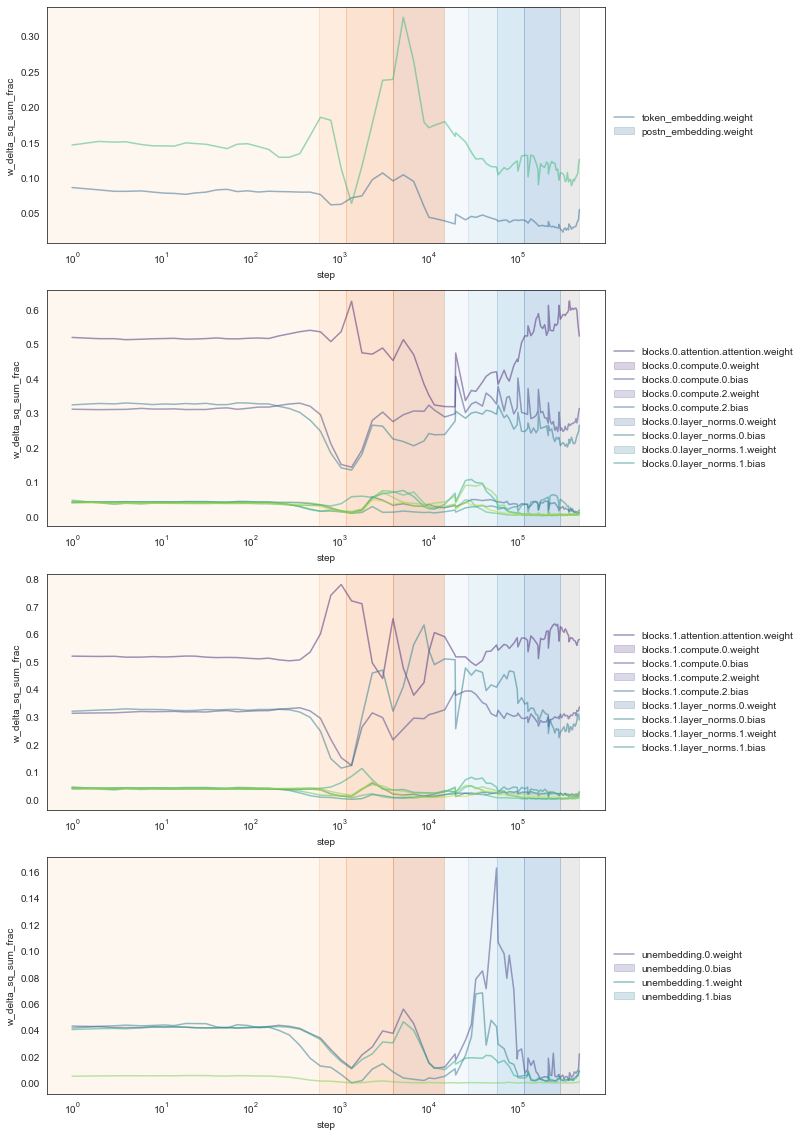

In [328]:
fig, axes = plt.subplots(len(groupings), figsize=(10, 20))

for ax, grouping in zip(axes, groupings):
    sns.lineplot(data=contributions.loc[contributions.layer.isin(grouping)], x="step", y="w_delta_sq_sum_frac", hue="layer", palette="viridis", ax=ax, alpha=0.5)

    labels = [l.split(".")[1:] for l in grouping]
    labels = [".".join(l) for l in labels]
    ax.legend(labels=labels, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, frameon=False)

    # ax.legend().remove()
    ax.set_xscale('log')


# ax.set_yscale('log')
plot_transitions(axes, TRANSITIONS)


## Hessians

In [156]:
import pyhessian
from pyhessian import hessian # Hessian computation

class ModelWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, inputs):
        return self.model(inputs[0], inputs[1])
    
ref_model = ModelWrapper(deepcopy(models[-1]).to('cpu'))
hessian_comp = hessian(ref_model, F.mse_loss, data=((xs, ys), ys), cuda=False)

In [159]:
def torch_eig_wrapper(*args, eigenvectors=True, **kwargs):
    # Call the new torch.linalg.eig function
    eigenvalues, eigenvecs = torch.linalg.eig(*args, **kwargs)
    
    # Format the output to mimic the old torch.eig
    # torch.eig used to return a tensor with [real, imaginary] parts for eigenvalues
    # torch.linalg.eig returns a tensor of complex numbers for eigenvalues
    eigenvalues_real = eigenvalues.real
    eigenvalues_imag = eigenvalues.imag

    eigenvalues_combined = torch.stack((eigenvalues_real, eigenvalues_imag), dim=-1)
    return eigenvalues_combined, eigenvecs

# Monkey patch the torch.eig function in the pyhessian module
torch.eig = torch_eig_wrapper 

density_eigen, density_weight = hessian_comp.density()

<ipython-input-161-72e34e31aabb>:25: ComplexWarning: Casting complex values to real discards the imaginary part
  density_output[i, j] = np.sum(tmp_result * weights[i, :])


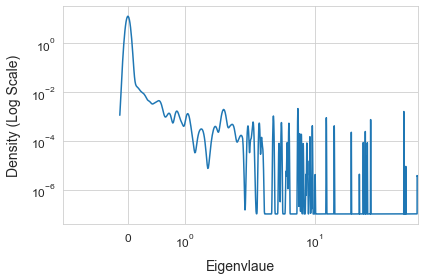

In [161]:
# From PyHessian

def density_generate(eigenvalues,
                     weights,
                     num_bins=10000,
                     sigma_squared=1e-5,
                     overhead=0.01):

    eigenvalues = np.array(eigenvalues)
    weights = np.array(weights)

    lambda_max = np.mean(np.max(eigenvalues, axis=1), axis=0) + overhead
    lambda_min = np.mean(np.min(eigenvalues, axis=1), axis=0) - overhead

    grids = np.linspace(lambda_min, lambda_max, num=num_bins)
    sigma = sigma_squared * max(1, (lambda_max - lambda_min))

    num_runs = eigenvalues.shape[0]
    density_output = np.zeros((num_runs, num_bins))

    for i in range(num_runs):
        for j in range(num_bins):
            x = grids[j]
            tmp_result = gaussian(eigenvalues[i, :], x, sigma)
            density_output[i, j] = np.sum(tmp_result * weights[i, :])
    density = np.mean(density_output, axis=0)
    normalization = np.sum(density) * (grids[1] - grids[0])
    density = density / normalization
    return density, grids


def gaussian(x, x0, sigma_squared):
    return np.exp(-(x0 - x)**2 /
                  (2.0 * sigma_squared)) / np.sqrt(2 * np.pi * sigma_squared)

def get_esd_plot(eigenvalues, weights):
    density, grids = density_generate(eigenvalues, weights)
    plt.semilogy(grids, density + 1.0e-7)
    plt.ylabel('Density (Log Scale)', fontsize=14, labelpad=10)
    plt.xlabel('Eigenvlaue', fontsize=14, labelpad=10)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.axis([np.min(eigenvalues) - 1, np.max(eigenvalues) + 1, None, None])
    plt.xscale('symlog')
    plt.tight_layout()

get_esd_plot(density_eigen, density_weight)

In [162]:
top_evals = []
hessian_traces = []

xs = xs.to('cpu')
ys = ys.to('cpu')

for model in tqdm.tqdm(models):
    model = model.to('cpu')
    ref_model = ModelWrapper(model)
    hessian_comp = hessian(ref_model, F.mse_loss, data=((xs, ys), ys), cuda=False)

    _top_evals, _ = hessian_comp.eigenvalues(top_n=3)
    trace = hessian_comp.trace()

    top_evals.append(_top_evals)
    hessian_traces.append(trace)

    model.to('mps')

xs = xs.to('mps')
ys = ys.to('mps')

100%|██████████| 96/96 [2:34:50<00:00, 96.78s/it]   


In [ ]:
densities_over_time = []

xs = xs.to('cpu')
ys = ys.to('cpu')

steps_to_models = dict(zip(steps, models))
models_subset = [steps_to_models[step] for step in highlight_steps]

for step, model in tqdm.tqdm(zip(highlight_steps, models_subset)):
    print(step)
    model = model.to('cpu')
    ref_model = ModelWrapper(model)
    hessian_comp = hessian(ref_model, F.mse_loss, data=((xs, ys), ys), cuda=False)
    density_eigen, density_weight = hessian_comp.density()
    densities_over_time.append((density_eigen, density_weight))

    get_esd_plot(density_eigen, density_weight)
    plt.show()

    model.to('mps')

xs = xs.to('mps')
ys = ys.to('mps')

## Parametric Essential Dynamics

In [ ]:
# Let's try this for restricted subsets of weights as well

from typing import Callable


def extract_weights_over_checkpoints(models: Iterable[nn.Module], extract_weights: Callable = lambda m: [p.flatten() for p in m.parameters()], normalize=False):
    for model in models:
        weights = torch.cat(extract_weights(model)).detach().cpu().numpy()

        if normalize:
            weights /= np.linalg.norm(weights)

        yield weights



def get_pca_weights_trace(models: Iterable[nn.Module], extract_weights: Callable = lambda m: [p.flatten() for p in m.parameters()], num_components=3, normalize=False) -> Dict[str, Tuple[PCA, np.ndarray]]:
    weights = np.array([w for w in extract_weights_over_checkpoints(models, extract_weights, normalize=normalize)])

    pca = PCA(n_components=num_components)
    weights_reduced = pca.fit_transform(weights)

    return weights_reduced, pca

all_weights, weights_pca = get_pca_weights_trace(models, num_components=3, normalize=False)

plot_multiple_slices(
    steps, 
    all_weights, 
    weights_pca, 
transitions,

    transitions_of_steps,
    connect_dots=True, 
    save=None,
)
plt.show()


In [ ]:
extract_embedding_weights = lambda m: [p.flatten() for p in m.token_sequence_transformer.token_embedding.parameters()]
extract_unembedding_weights = lambda m: [p.flatten() for p in m.token_sequence_transformer.unembedding[1].parameters()]
extract_embedding_unembedding_weights = lambda m: [p.flatten() for p in m.token_sequence_transformer.token_embedding.parameters()] + [p.flatten() for p in m.token_sequence_transformer.unembedding[1].parameters()]
extract_block_0_weights = lambda m: [p.flatten() for p in m.token_sequence_transformer.blocks[0].parameters()]
extract_block_1_weights = lambda m: [p.flatten() for p in m.token_sequence_transformer.blocks[1].parameters()]
extract_lns = lambda m: [m.state_dict()[f"{ln}.{part}"] for ln in layer_norms for part in ["weight", "bias"]]
extract_mlp_0 = lambda m: [p.flatten() for p in m.token_sequence_transformer.blocks[0].compute[0].parameters()] + [p.flatten() for p in m.token_sequence_transformer.blocks[0].compute[2].parameters()]
extract_mlp_1 = lambda m: [p.flatten() for p in m.token_sequence_transformer.blocks[1].compute[0].parameters()] + [p.flatten() for p in m.token_sequence_transformer.blocks[1].compute[2].parameters()]
extract_attn_0 = lambda m: [p.flatten() for p in m.token_sequence_transformer.blocks[0].attention.attention.parameters()]
extract_attn_1 = lambda m: [p.flatten() for p in m.token_sequence_transformer.blocks[1].attention.attention.parameters()]

extract_weights_fns = {
    "Embedding & Unembedding": extract_embedding_unembedding_weights, 
    "Unembedding": extract_unembedding_weights, 
    "Embedding": extract_embedding_weights, 
    "Block 0": extract_block_0_weights, 
    "Block 1": extract_block_1_weights, 
    "Layer norms": extract_lns,
    "MLP 0": extract_mlp_0,
    "MLP 1": extract_mlp_1,
    "Attention 0": extract_attn_0,
    "Attention 1": extract_attn_1,
}

for label, extract_weights in extract_weights_fns.items():
    print(label)

    for normalize in [False, True]:
        print(f"Normalize: {normalize}")
        subset_weights, weights_pca = get_pca_weights_trace(models, num_components=3, extract_weights=extract_weights, normalize=normalize)

        plot_multiple_slices(
            steps, 
            subset_weights, 
            weights_pca, 
            highlight_steps,
            transitions_of_steps,
            connect_dots=True, 
            save=None,
        )
        plt.show()



## Embedding

In [228]:
steps = run.checkpointer.file_ids
embedding_matrices = []  # Shape: (64, 5): 64 vectors x (1 y dim + 4 x dims)

for model in models:
    embedding_matrices.append(model.state_dict()['token_sequence_transformer.token_embedding.weight'])


embedding_vec_x_norms = [vec.norm(dim=1) for vec in embedding_matrices]  # (64,)

/Users/Jesse/Projects/icl/icl/figures/colors.py:70: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(min_step, max_step)


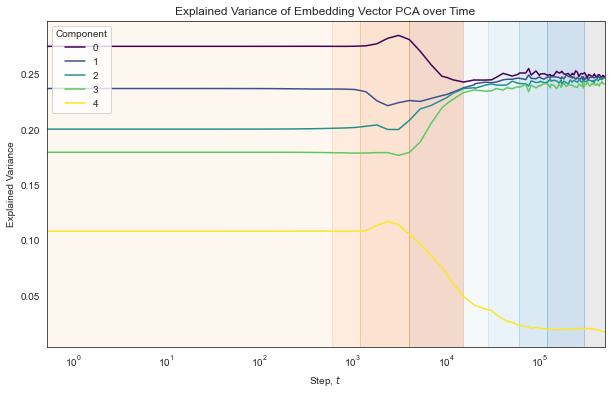

In [229]:
# PCA explained Variance over time
pcas = []

for model in models:
    embed = model.token_sequence_transformer.token_embedding.weight.detach().cpu().numpy()
    pca = PCA(n_components=embed.shape[1])
    proj = pca.fit_transform(embed)[:,:3]
    pcas.append((proj, pca))

explained_variances = [{"value": value, "index": idx, "step": step} for step, (_, pca) in zip(steps, pcas) for idx, value in enumerate(pca.explained_variance_ratio_)]
explained_variances = pd.DataFrame(explained_variances)

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=explained_variances, x="step", y="value", hue="index", palette="viridis", ax=ax)
ax.legend(title="Component", loc='upper left')
ax.set_xscale('log')
ax.set_title("Explained Variance of Embedding Vector PCA over Time")
ax.set_ylabel("Explained Variance")
ax.set_xlabel("Step, $t$")

fig.set_facecolor('white')
plot_transitions(ax, TRANSITIONS, limit=True)

/Users/Jesse/Projects/icl/icl/figures/colors.py:70: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(min_step, max_step)


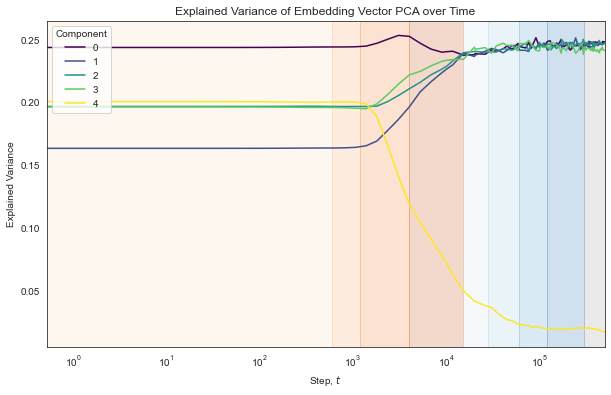

In [230]:
# Using the final PCA

def compute_explained_variance(pca, embed):
    proj = pca.transform(embed)

    # Step 4 and 5: Compute variance of projected data and total variance
    variance_projected = np.var(proj, axis=0)
    total_variance = np.sum(variance_projected)

    # Step 6: Calculate explained variance ratio
    explained_variance_ratio = variance_projected / total_variance

    return explained_variance_ratio

explained_variances_rel_last_pca = [{"value": value, "index": idx, "step": step} for step, embed in zip(steps, embedding_matrices) for idx, value in enumerate(compute_explained_variance(pcas[-1][-1], embed.detach().cpu().numpy()))]
explained_variances_rel_last_pca = pd.DataFrame(explained_variances_rel_last_pca)

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=explained_variances_rel_last_pca, x="step", y="value", hue="index", palette="viridis", ax=ax)
ax.legend(title="Component", loc='upper left')

ax.set_xscale('log')
ax.set_title("Explained Variance of Embedding Vector PCA over Time")
ax.set_ylabel("Explained Variance")
ax.set_xlabel("Step, $t$")

fig.set_facecolor('white')

plot_transitions(ax, TRANSITIONS, limit=True)

In [ ]:
# Let's project embedding vectors onto these pca components and track their evolution
last_pca = pcas[-1][-1]
transformed = [last_pca.transform(embed.detach().cpu().numpy()) for embed in embedding_matrices]
transition_middles = [get_nearest_step((t[0] + t[1]) * 0.5) for t in TRANSITIONS]

fig, axes = plt.subplots(1, len(transition_middles), figsize=(20, 5))

min_x, max_x = 0, 0
min_y, max_y = 0, 0

for ax, middle in zip(axes, transition_middles):
    middle_idx = steps.index(middle)
    middle_embeddings = transformed[middle_idx]
    sns.scatterplot(data=pd.DataFrame(middle_embeddings), x=0, y=1, ax=ax)
    ax.set_title(f"Step {middle}")

    min_x = min(min_x, middle_embeddings[:, 0].min())
    max_x = max(max_x, middle_embeddings[:, 0].max())
    min_y = min(min_y, middle_embeddings[:, 1].min())
    max_y = max(max_y, middle_embeddings[:, 1].max())

for ax in axes:
    ax.set_xlim(min_x * 1.25, max_x * 1.25)
    ax.set_ylim(min_y * 1.25, max_y * 1.25)


In [231]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Assuming 'pcas', 'embedding_matrices', 'TRANSITIONS', and 'steps' are defined as in your context.

last_pca = pcas[-1][-1]
transformed = [last_pca.transform(embed.detach().cpu().numpy()) for embed in embedding_matrices]
transition_middles = [get_nearest_step((t[0] + t[1]) * 0.5) for t in TRANSITIONS]

min_x, max_x = min([t[:, 0].min() for t in transformed]), max([t[:, 0].max() for t in transformed])
min_y, max_y = min([t[:, 1].min() for t in transformed]), max([t[:, 1].max() for t in transformed])

# Set up the figure.
fig, ax = plt.subplots(figsize=(8, 6))
plt.xlim(min_x * 1.25, max_x * 1.25)
plt.ylim(min_y * 1.25, max_y * 1.25)
scat = ax.scatter([], [])

# Update function for the animation.
def update(frame):
    middle_embeddings = transformed[frame]
    ax.clear()
    ax.set_xlim(min_x * 1.25, max_x * 1.25)
    ax.set_ylim(min_y * 1.25, max_y * 1.25)
    ax.set_title(f"Step {steps[frame]}")
    sns.scatterplot(data=pd.DataFrame(middle_embeddings), x=0, y=1, ax=ax)

# Create the animation.
ani = FuncAnimation(fig, update, frames=range(len(steps)), repeat=False)

# To save the animation, you can use the following line:
ani.save(FIGURES / 'M1-embed.mp4', writer='ffmpeg', fps=1)

plt.show()


KeyboardInterrupt: 

## Unembedding

In [359]:
unembeddings = []

for step, model in zip(steps, models):
    for subset in ["weight", "bias"]:
        layer = f"ln.{subset}"
        for i, param in enumerate(getattr(model.token_sequence_transformer.unembedding[0], subset)):
            unembeddings.append({"p": param.item(), "step": step, "layer": layer, "i": i})

        layer = f"linear.{subset}"
        layer_param = getattr(model.token_sequence_transformer.unembedding[1], subset)
        if subset == "weight":
            layer_param = layer_param[0, :]
            for i, param in enumerate(layer_param):
                unembeddings.append({"p": param.item(), "step": step, "layer": layer, "i": i})
        else:
            layer_param = layer_param[0]
            unembeddings.append({"p": layer_param.item(), "step": step, "layer": layer, "i": 0})


unembeddings = pd.DataFrame(unembeddings)

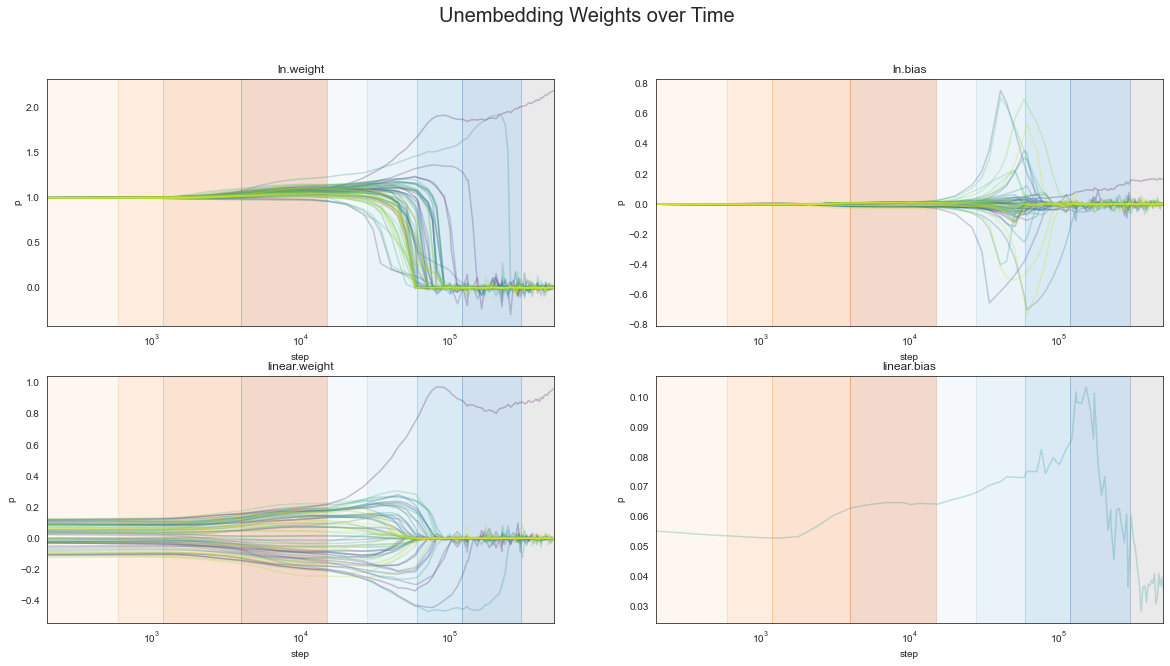

In [360]:
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

for i, layer in enumerate(["ln", "linear"]):
    for j, layer_subset in enumerate(["weight", "bias"]):
        sns.lineplot(data=unembeddings.loc[unembeddings.layer == f"{layer}.{layer_subset}"], x="step", y="p", hue="i", palette="viridis", ax=axes[i, j], alpha=0.25)
        axes[i, j].legend().remove()
        axes[i, j].set_xscale('log')
        axes[i, j].set_title(f"{layer}.{layer_subset}")

        axes[i, j].set_xlim(200, 500000)


fig.suptitle("Unembedding Weights over Time", fontsize=20)

plot_transitions(axes, TRANSITIONS);


Given $z$, the activations in the residual stream right before the unembedding, a 64-dimensional vector (per token). 

The unembedding performs the following operation: 

$$
\pi_y \left[ W_U \cdot \left( \frac{z-\mathbb E[z]}{\sqrt{\mathbb V[z] + \epsilon}} * \gamma + \beta \right) + b_U \right].
$$

This can be rewritten as follows:

$$
\left((W_U)_{[0, :]} * \gamma \right) \cdot \left(\frac{z-\mathbb E[z]}{\sqrt{\mathbb V[z] + \epsilon}}\right) + \left((W_U)_{[0, :]} \cdot \beta\right) + (b_U)_{[0]}
$$

Let's look at these "reduced" weights instead:
$$
\tilde W_U = (W_U)_{[0, :]} * \gamma,
$$
and
$$
\tilde b_U = \left((W_U)_{[0, :]} \cdot \beta\right) + (b_U)_{[0]}.
$$

How do you get around the $\mathbb E[z]$? (For now, assume that $\mathbb V[z]=1-\epsilon$).
Answer: You make sure that $\mathbb E[z] = 0$. 

Let's look at two possible implementations:

**1: One-hot $z$**

Suppose $z$ contains mostly balanced white noise. The signal (which we'll read the final prediction from) is contained in a single dimension $j$. 
Then, from the perspective of the average, we can view $z$ as a 1-hot vector, 

$$
z_i = z_j \delta_{ij}.
$$

Then, the average is

$$
\mathbb E[z] = \frac{1}{d_E} \sum_{j=1}^{d_E} z_j = \frac{1}{M} z_i,
$$

where $d_E=64$ is the dimension of the embedding / residual stream, and 

$$
z - \mathbb E[z] =  z_j \left(1 - \frac{1}{d_E}\right) \delta_{ij}.
$$

By setting $\gamma_j = \frac{d_E}{d_E-1}$, and we're able to read out the prediction. 

**2: Balanced $z$**

Again, assume that most components of $z$ contain balanced white noise. This time, however, we assume the signal is contained in two dimensions, $j$ and $k$. Assume that the signal is encoded with opposite magnitudes:

$$
z_i = z_j (\delta_{ij} - \delta_{ik}).
$$

Then, the average is:

$$
\mathbb E[z] = z_j \left(1 - 1\right) / d_E = 0.
$$

**During B2, we see a transition from (2) to (1).**

And if you look back further, we see additional transitions of this kind, where we have two negatively encoded signals that collapse together. 

Okay but why?

**Now, let's reintroduce the $\mathbb V[z]$ term.**

The problem with this term is that the input $x$ does not have a fixed norm, so the variance depends on $\mathbb V[x]$. 
The key observation is that we can set several extra dimensions in the residual stream to values that are arbitraily large in value. 

That is, by increasing the variance of the white noise contributions, we can suppress the contribution of the variance of the input and set $\mathbb V[z]$ to an arbitrary fixed value $v$ that we can cancel out with $\gamma$. 

Because (2) has the signal redundantly encoded, the contribution from $\mathbb V[x]$ is larger. So we can reduce the loss by changing to (1). 
But this also increases the degeneacy! As soon as $z_k$ no longer contains a signal, it can freely mix with all the other white noise contributions. We move from a set of $O(d_E-2)$ symmetries to a set of $O(d_E-1)$ symmetries.

Unfortunately, this transition doesn't have a Bayesian antecedent. Or does it? Remember, the $\gamma_i$ in the layer norm are initialized at $1$. So it's still very much possible that we have an "A-B" transition in which both loss and learning coefficient decrease in exchange for a significant increase in the prior contribution. 

In [471]:
reduced_unembeddings = []

for step, model in zip(steps, models):
    reduced_weight = model.token_sequence_transformer.unembedding[1].weight[0, :] * model.token_sequence_transformer.unembedding[0].weight
    reduced_bias = model.token_sequence_transformer.unembedding[1].weight[0, :] @ model.token_sequence_transformer.unembedding[0].bias + model.token_sequence_transformer.unembedding[1].bias[0]

    for i, param in enumerate(reduced_weight):
        reduced_unembeddings.append({"p": param.item(), "subset": "weight", "step": step,  "i": i})

    reduced_unembeddings.append({"p": reduced_bias.item(), "subset": "bias", "step": step,  "i": 0})

reduced_unembeddings = pd.DataFrame(reduced_unembeddings)

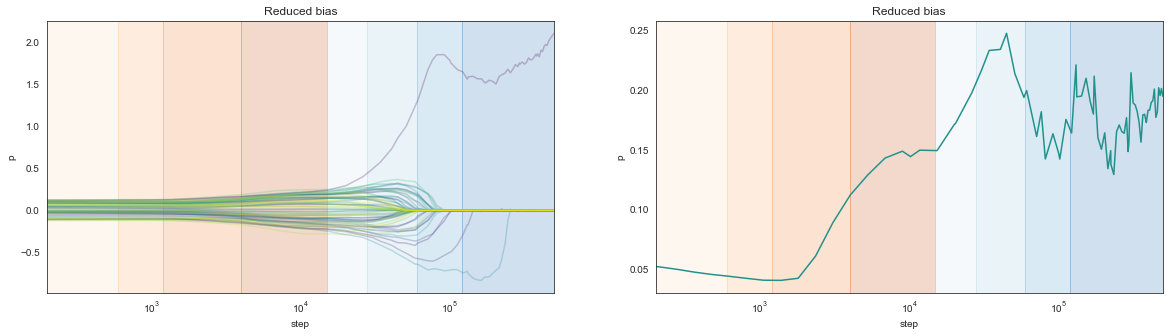

In [472]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))


ax = axes[0]
sns.lineplot(data=reduced_unembeddings.loc[reduced_unembeddings.subset == "weight"], x="step", y="p", hue="i", palette="viridis", ax=ax, alpha=0.25)
ax.set_title(f"{layer}.{layer_subset}")

ax = axes[1]
sns.lineplot(data=reduced_unembeddings.loc[reduced_unembeddings.subset == "bias"], x="step", y="p", hue="i", palette="viridis", ax=ax)

for ax in axes:
    ax.legend().remove()
    ax.set_xscale('log')
    ax.set_title(f"Reduced {layer_subset}")
    ax.set_xlim(200, 500000)

plot_transitions(axes, TRANSITIONS);

## Zero ablations

In [329]:
bias_stats = []

for step, model in zip(steps, models):
    state_dict = model.state_dict()

    bias_stats.append({
        "step": step,
        "postn_embedding_norm": state_dict["token_sequence_transformer.postn_embedding.weight"].norm().item(),
        "unembedding_ln_bias_norm": state_dict["token_sequence_transformer.unembedding.0.bias"].norm().item(),    
    })

bias_stats = pd.DataFrame(bias_stats)

In [330]:
postn_embeddings = []
unembedding_biases = []

for step, model in zip(steps, models):
    state_dict = model.state_dict()

    _postn_embedding = state_dict["token_sequence_transformer.postn_embedding.weight"]

    for i, p in enumerate(_postn_embedding):
        postn_embeddings.append({
            "step": step,
            "postn_embedding_0": p[0].item(),
            "idx": i,
            "postn_embedding_x_std": p[::2].std().item(),
            "postn_embedding_x_mean": p[::2].mean().item(),
            "postn_embedding_y_std": p[1::2].std().item(),
            "postn_embedding_y_mean": p[1::2].mean().item(),
        })

    _unembedding_bias = state_dict["token_sequence_transformer.unembedding.0.bias"]
    for i, p in enumerate(_unembedding_bias):
        unembedding_biases.append({
            "step": step,
            "unembedding_bias": p.item(),
            "idx": i
        })

postn_embeddings = pd.DataFrame(postn_embeddings)
unembedding_biases = pd.DataFrame(unembedding_biases)

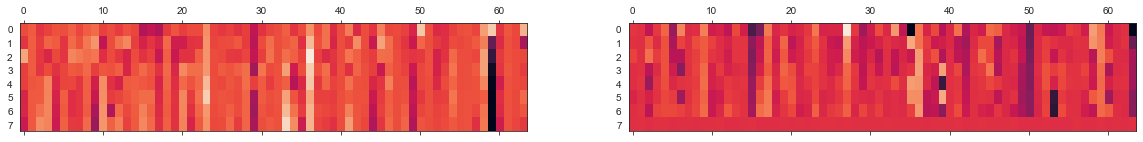

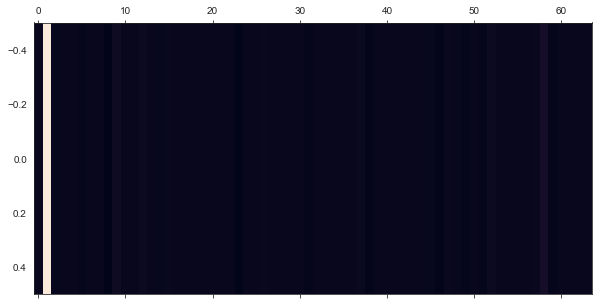

In [331]:
fig, axes = plt.subplots(1, 2, figsize=(20, 2))

axes[0].matshow(models[-1].token_sequence_transformer.postn_embedding.weight[:, ::2].T.detach().cpu().numpy(), aspect="auto")
axes[1].matshow(models[-1].token_sequence_transformer.postn_embedding.weight[:, 1::2].T.detach().cpu().numpy(), aspect="auto")

plt.show()

fig, ax = plt.subplots(figsize=(10, 5))

ax.matshow(models[-1].token_sequence_transformer.unembedding[0].bias.reshape((1, 64)).detach().cpu().numpy(), aspect="auto")

/Users/Jesse/Projects/icl/icl/figures/colors.py:70: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(min_step, max_step)


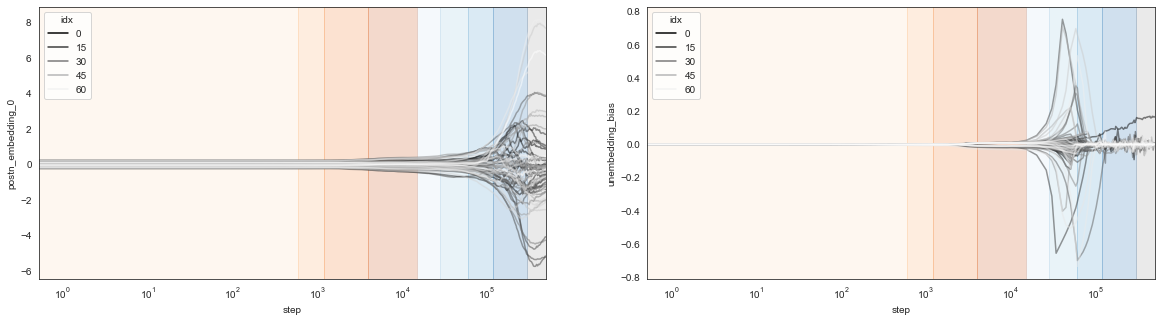

In [332]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

ax = axes[0]
# sns.lineplot(data=bias_stats, x="step", y="postn_embedding_norm", ax=ax)
sns.lineplot(data=postn_embeddings, x="step", y="postn_embedding_0", hue="idx", palette="gray", ax=ax, alpha=0.5)

ax.set_xscale("log")

ax = axes[1]
# sns.lineplot(data=bias_stats, x="step", y="unembedding_ln_bias_norm", ax=ax)
sns.lineplot(data=unembedding_biases, x="step", y="unembedding_bias", hue="idx", palette="gray", ax=ax, alpha=0.5)
ax.set_xscale("log")

plot_transitions(axes, TRANSITIONS, limit=True)

(4,) (5,)


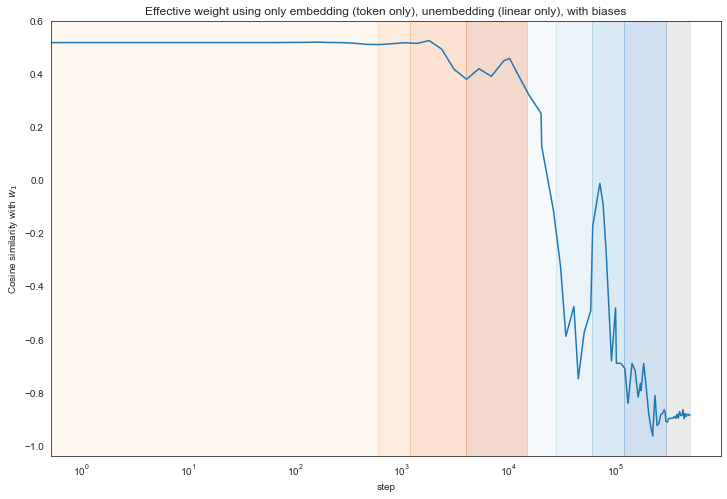

In [333]:
from matplotlib import patches
from icl.model import to_token_sequence, from_predicted_token_sequence

class EmbedUnembedOnlyV2(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.to_token_sequence = to_token_sequence
        self.token_embedding = model.token_sequence_transformer.token_embedding
        self.positional_embedding = model.token_sequence_transformer.postn_embedding
        self.unembedding = model.token_sequence_transformer.unembedding
        self.from_predicted_token_sequence = from_predicted_token_sequence

    def forward(self, xs, ys):
        tokens = self.to_token_sequence(xs, ys)

        T = tokens.shape[1]
        x = self.token_embedding(tokens) # + self.positional_embedding.weight.T[:T, :]
        # Set everything to zero except for dimensions 46 and 51
        # embedded[:, :, :46] = 0
        # embedded[:, :, 47:51] = 0
        # embedded[:, :, 52:] = 0

        x = self.unembedding[0](x)
        unembedded = self.unembedding[1](x)

        # raise ValueError("Done")
    
        return self.from_predicted_token_sequence(unembedded)


# embed_unembed_only_model = EmbedUnembedOnly(run.model)

def get_embed_unembed_with_bias(model, multiplier=1.):
    eu_model = EmbedUnembedOnlyV2(model).to('cpu')

    w = np.zeros(4)
    basis = torch.eye(4, device="cpu") * multiplier
    ys = torch.zeros(1, 1, 1, device="cpu") 

    for i in range(4):
        w[i] = eu_model(basis[i].unsqueeze(0).unsqueeze(0), ys)[0].item()

    return w


embed_unembed_with_bias = [
    get_embed_unembed_with_bias(model, 10)
    for model in models
]

print(embed_unembed_with_bias[0].shape, task_embed.shape)

cossims = [
    (v @ task_np) / (np.linalg.norm(v) * np.linalg.norm(task_np)) for v in embed_unembed_with_bias
]

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(run.checkpointer.file_ids, cossims)
ax.set_xscale("log")
ax.set_xlabel("step")
ax.set_ylabel(r"Cosine similarity with $w_1$")
ax.set_title("Effective weight using only embedding (token only), unembedding (linear only), with biases")

# plt.legend(loc='lower left')
plot_transitions(ax, TRANSITIONS)
fig.set_facecolor('white')

## Layer norms

In [ ]:
models[0].state_dict().keys()

In [277]:
from icl.analysis.slt import prepend_keys

layer_norms = [
    "token_sequence_transformer.unembedding.0",
    "token_sequence_transformer.blocks.0.layer_norms.0",
    "token_sequence_transformer.blocks.0.layer_norms.1",
    "token_sequence_transformer.blocks.1.layer_norms.0",
    "token_sequence_transformer.blocks.1.layer_norms.1",
]

list(model.state_dict().keys())

def get_ln(model, key):
    return (model.state_dict()[f'{key}.weight'], model.state_dict()[f'{key}.bias'])

unembedding_lns = [get_ln(model, 'token_sequence_transformer.unembedding.0') for model in models]
block_1_attn_lns =  [get_ln(model, 'token_sequence_transformer.blocks.0.layer_norms.0') for model in models]
block_1_mlp_lns =  [get_ln(model, 'token_sequence_transformer.blocks.0.layer_norms.1') for model in models]
block_2_attn_lns =  [get_ln(model, 'token_sequence_transformer.blocks.1.layer_norms.0') for model in models]
block_2_mlp_lns =  [get_ln(model, 'token_sequence_transformer.blocks.1.layer_norms.1') for model in models]

def ln_norm(weight, bias):
    return torch.norm(weight).detach().cpu().numpy()

def ln_norm_std(weight, bias):
    return torch.std(weight.abs()).detach().cpu().numpy()

unembedding_ln_norms = [ln_norm(weight, bias) for weight, bias in unembedding_lns]
block_1_attn_ln_norms = [ln_norm(weight, bias) for weight, bias in block_1_attn_lns]
block_1_mlp_ln_norms = [ln_norm(weight, bias) for weight, bias in block_1_mlp_lns]
block_2_attn_ln_norms = [ln_norm(weight, bias) for weight, bias in block_2_attn_lns]
block_2_mlp_ln_norms = [ln_norm(weight, bias) for weight, bias in block_2_mlp_lns]

unembedding_ln_norms_std = np.array([ln_norm_std(weight, bias) for weight, bias in unembedding_lns])
block_1_attn_ln_norms_std = np.array([ln_norm_std(weight, bias) for weight, bias in block_1_attn_lns])
block_1_mlp_ln_norms_std = np.array([ln_norm_std(weight, bias) for weight, bias in block_1_mlp_lns])
block_2_attn_ln_norms_std = np.array([ln_norm_std(weight, bias) for weight, bias in block_2_attn_lns])
block_2_mlp_ln_norms_std = np.array([ln_norm_std(weight, bias) for weight, bias in block_2_mlp_lns])

def frac_nonzero(weight, eps=1e-1):
    return (weight.abs() > eps).float().mean().detach().cpu().numpy()

unembedding_ln_norm_nonzero = [frac_nonzero(weight) for weight, bias in unembedding_lns]
block_1_attn_ln_norm_nonzero = [frac_nonzero(weight) for weight, bias in block_1_attn_lns]
block_1_mlp_ln_norm_nonzero = [frac_nonzero(weight) for weight, bias in block_1_mlp_lns]
block_2_attn_ln_norm_nonzero = [frac_nonzero(weight) for weight, bias in block_2_attn_lns]
block_2_mlp_ln_norm_nonzero = [frac_nonzero(weight) for weight, bias in block_2_mlp_lns]

ln_stats = []

def get_stats(weight):
    return {
        "norm": weight.norm().item(),
        "norm_std": weight.abs().std().item(),
        "std": weight.std().item(),
        "mean": weight.mean().item(),
        "max": weight.max().item(),
        "min": weight.min().item(),
    }
    

for step, model in zip(steps, models):
    for layer in ["unembedding.0", "blocks.0.layer_norms.0", "blocks.0.layer_norms.1", "blocks.1.layer_norms.0", "blocks.1.layer_norms.1"]:
        weight, bias = get_ln(model, f"token_sequence_transformer.{layer}")

        ln_stats.append({
            "step": step,
            "layer": layer,
            "layer_pretty": layer.replace("_", " ").title(),
            **prepend_keys(get_stats(weight), "weight"),
            **prepend_keys(get_stats(bias), "bias"),
        })

ln_stats = pd.DataFrame(ln_stats)
ln_stats

,step,layer,layer_pretty,weight/norm,weight/norm_std,weight/std,weight/mean,weight/max,weight/min,bias/norm,bias/norm_std,bias/std,bias/mean,bias/max,bias/min
0,0,unembedding.0,Unembedding.0,8.000000,4.866699e-08,4.866699e-08,1.000000,1.000000,1.000000,3.200002e-07,7.342409e-13,3.960119e-08,-7.500113e-09,4.000015e-08,-4.000015e-08
1,0,blocks.0.layer_norms.0,Blocks.0.Layer Norms.0,8.000000,4.629154e-08,4.629154e-08,1.000000,1.000000,1.000000,3.200008e-07,7.384313e-14,4.000011e-08,5.000014e-09,4.000015e-08,-4.000015e-08
2,0,blocks.0.layer_norms.1,Blocks.0.Layer Norms.1,8.000000,3.973643e-08,3.973643e-08,1.000000,1.000000,1.000000,3.199935e-07,5.630592e-12,3.933909e-08,8.749384e-09,4.000014e-08,-4.000013e-08
3,0,blocks.1.layer_norms.0,Blocks.1.Layer Norms.0,8.000000,4.248003e-08,4.248003e-08,1.000000,1.000000,1.000000,3.200001e-07,3.462254e-13,4.029653e-08,1.250051e-09,4.000014e-08,-4.000014e-08
4,0,blocks.1.layer_norms.1,Blocks.1.Layer Norms.1,8.000000,4.113111e-08,4.113111e-08,1.000000,1.000000,1.000000,3.199962e-07,1.392785e-12,4.029603e-08,-1.250367e-09,4.000009e-08,-4.000011e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,499999,unembedding.0,Unembedding.0,2.192975,2.739246e-01,2.739886e-01,0.035299,2.192798,-0.003083,1.651213e-01,2.055602e-02,2.063188e-02,2.644419e-03,1.647838e-01,-3.440797e-03
476,499999,blocks.0.layer_norms.0,Blocks.0.Layer Norms.0,2.022449,2.159772e-01,2.167387e-01,0.132926,0.815810,-0.006481,1.040211e+00,1.211873e-01,1.310503e-01,1.018738e-03,4.592762e-01,-4.733152e-01
477,499999,blocks.0.layer_norms.1,Blocks.0.Layer Norms.1,3.620858,3.536168e-01,3.580645e-01,0.280440,1.512446,-0.054016,4.494146e+00,5.520272e-01,5.644972e-01,-4.365247e-02,1.267353e+00,-4.253410e+00
478,499999,blocks.1.layer_norms.0,Blocks.1.Layer Norms.0,4.560251,3.756832e-01,3.760126e-01,0.430998,2.552187,-0.003471,3.091238e+00,3.749110e-01,3.894372e-01,-4.128579e-03,1.108022e+00,-2.831517e+00


Text(0.5, 1.0, 'Layer Norm Bias Norms over Time')

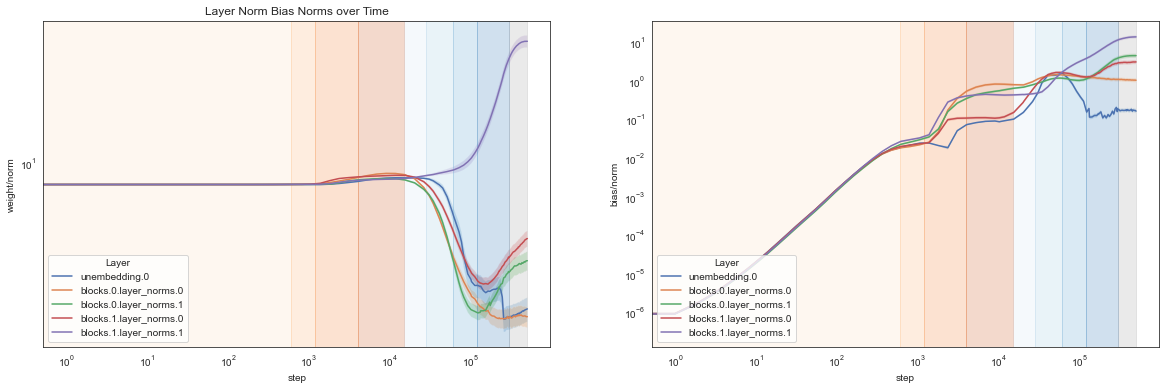

In [290]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Fill between using the std
for i, type_ in enumerate(["weight", "bias"]):
    sns.lineplot(data=ln_stats, x="step", y=f"{type_}/norm", hue="layer", palette="deep", ax=axes[i])

    for layer in ln_stats.layer.unique():
        layer_ln_stats = ln_stats.loc[ln_stats.layer == layer]
        axes[i].fill_between(steps, layer_ln_stats[f"{type_}/norm"] - layer_ln_stats[f"{type_}/norm_std"], layer_ln_stats[f"{type_}/norm"] + layer_ln_stats[f"{type_}/norm_std"], alpha=0.2)

for ax in axes.flatten():
    ax.legend(title="Layer", loc='lower left')
    plot_transitions(ax, TRANSITIONS)
    ax.set_xscale('log')
    ax.set_yscale('log')
    # ax.set_xlim(100, 500_000)

axes[0].set_title("Layer Norm Weight Norms over Time")
axes[0].set_title("Layer Norm Bias Norms over Time")

In [481]:
all_lns = {
    "Unembedding": unembedding_lns,
    "Block 1 Attention": block_1_attn_lns,
    "Block 1 MLP": block_1_mlp_lns,
    "Block 2 Attention": block_2_attn_lns,
    "Block 2 MLP": block_2_mlp_lns,
}

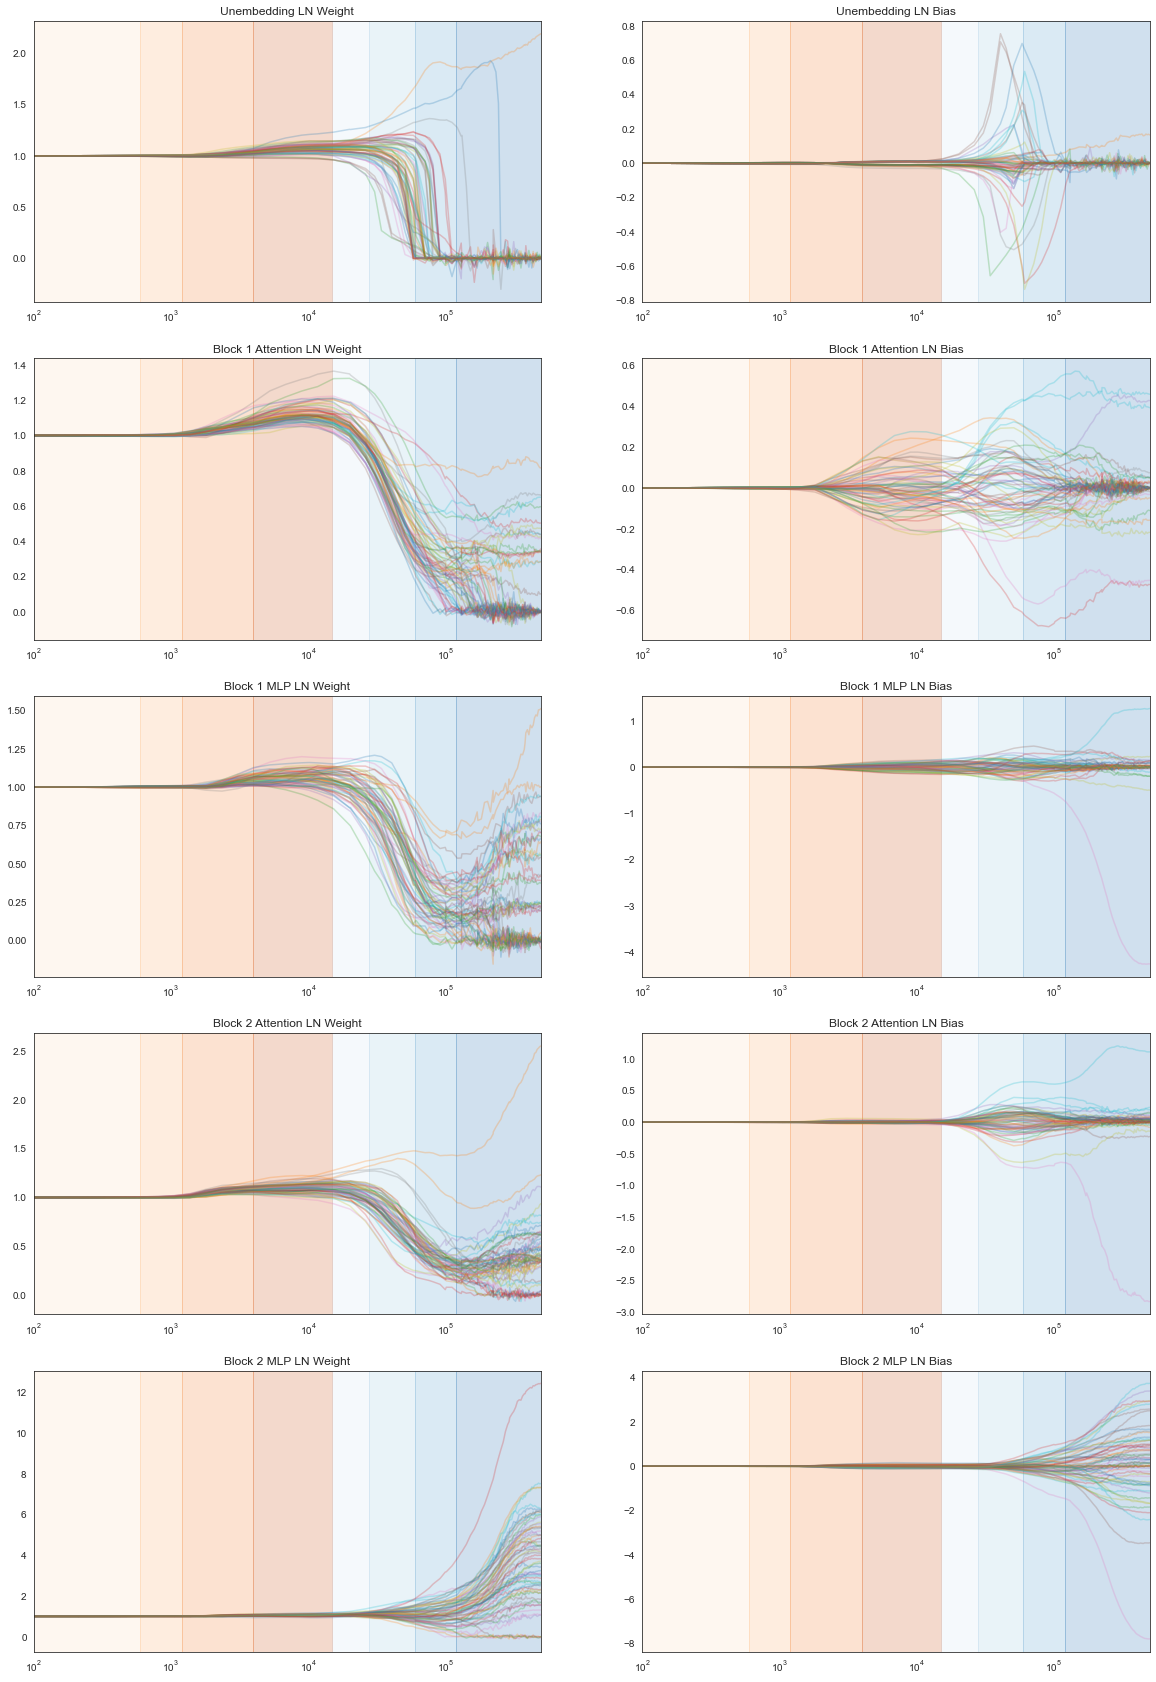

In [488]:
fig, axes = plt.subplots(len(all_lns), 2, figsize=(20, 30))

for i, (name, lns) in enumerate(all_lns.items()):
    axes[i, 0].plot(steps, np.array([w.detach().cpu().numpy() for w, b in lns]), alpha=0.25)
    axes[i, 1].plot(steps, np.array([b.detach().cpu().numpy() for w, b in lns]), alpha=0.25)

    axes[i, 0].set_title(f"{name} LN Weight")
    axes[i, 1].set_title(f"{name} LN Bias")

plot_transitions(axes, TRANSITIONS)

for ax in axes.flatten():
    ax.set_xscale('log')
    # ax.set_yscale('symlog')
    ax.set_xlim(100, 500000)

In [ ]:
labels = ["Unembed", "Block 1 Attn", "Block 1 MLP", "Block 2 Attn", "Block 2 MLP"]

for i, lns in enumerate([unembed_lns, block_1_attn_lns, block_1_mlp_lns, block_2_attn_lns, block_2_mlp_lns]):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    label = labels[i]
    lns_df = pd.DataFrame([{"step": step, "idx": i, "weight": weight.item(), "bias": bias.item()} for step, (weights, biases) in zip(steps, lns) for i, (weight, bias) in enumerate(zip(weights, biases))])

    ax = axes[0]
    # inset_ax_1 = ax.inset_axes([0.1, 0.1, 0.4, 0.4])

    sns.lineplot(data=lns_df, x="step", y="weight", color=PRIMARY, ax=ax)
    # sns.lineplot(data=lns_df, x="step", y="weight", hue="idx", palette="gray", ax=inset_ax_1, alpha=0.1)
    ax.set_title(f"{label} Layer Norm Weights over Time")
    ax.set_ylabel("$u_i$")
    ax.set_xlim(100, 500_000)
    
    ax = axes[1]
    # inset_ax_2 = ax.inset_axes([0.1, 0.1, 0.4, 0.4])

    sns.lineplot(data=lns_df, x="step", y="bias", color=PRIMARY, ax=ax)
    # sns.lineplot(data=lns_df, x="step", y="bias", hue="idx", palette="gray", ax=inset_ax_2, alpha=0.1)
    ax.set_title(f"{label} Layer Norm Biases over Time")
    ax.set_ylabel("$\mathrm{unembed bias}_i$")
    ax.set_xlim(100, 500_000)
    
    plot_transitions(axes, TRANSITIONS, limit=True)
    # plot_transitions(np.array([inset_ax_1, inset_ax_2]), TRANSITIONS, limit=True)

    for ax in axes:
        ax.set_xlabel("Step, $t$")
        ax.set_xscale('log')
        
    # for ax in [inset_ax_1, inset_ax_2]:
    #     ax.legend().remove()

    # for ax in [*axes, inset_ax_1, inset_ax_2]:
    #     ax.set_xscale('log')

    fig.set_facecolor('white')

    plt.show()


## Attention Entropies

In [ ]:
from collections import defaultdict
from typing import List, Union, Iterable, Optional
from torchtyping import TensorType
from devinfra.utils.iterables import map_nested

from icl.experiments.utils import iter_models
from devinfra.utils.iterables import flatten_dict

from icl.train import Run

def compute_attention_entropies(attn: TensorType["B", "H", "2K", "2K"]):
    """
    Computes the entropy of each token in each head, averaged across the batch, 
    then averages this over heads. 

    """
    
    # Threshold attention weights to avoid log(0)
    log_attention = torch.where(attn > 0, torch.log(attn), torch.tensor(0.0).to(attn.device))
    entropy_per_token = - torch.sum(attn * log_attention, dim=-1).mean(dim=0).squeeze(-1) # TensorType["H", "2K"]

    num_heads, num_tokens = entropy_per_token.shape

    entropy_per_head = entropy_per_token.mean(dim=-1) # TensorType["H"]
    entropy = entropy_per_head.mean() # TensorType[]    
    
    # Each token computes entropy over a variable context length, so we normalize by the maximum possible entropy
    # for a token with a fixed context length.

    max_entropy_per_token = torch.log2(torch.arange(1, num_tokens + 1).to(attn.device)) # TensorType["H", "2K"]
    max_entropy_per_token[0] = 1. # Special case for the first token to avoid dividing by 0

    entropy_per_token_normalized = entropy_per_token / max_entropy_per_token
    entropy_per_head_normalized = entropy_per_token_normalized.mean(dim=-1) # TensorType["H"]
    entropy_normalized = entropy_per_head_normalized.mean() # TensorType[]    

    results: Dict[str, Union[torch.Tensor, Dict[str, torch.Tensor]]] = {"mean": entropy, "mean_normalized": entropy_normalized}

    for i in range(num_heads):
        head_results = {"mean": entropy_per_head[i], "mean_normalized": entropy_per_head_normalized[i]}

        for j in range(num_tokens):
            head_results[f"token_{j}"] = entropy_per_token[i, j]
            head_results[f"token_{j}_normalized"] = entropy_per_token_normalized[i, j]

        results[f"head_{i}"] = head_results

    return map_nested(lambda x: convert_tensor(x, "np"), results)


def get_attention_entropies_trace(
    steps: List[int],
    models: Iterable[nn.Module],
    xs: torch.Tensor,
    ys: torch.Tensor,
    **paths,
):
    results = defaultdict(list)
    reverse_paths = {v: k for k, v in paths.items()}

    for activations in extract_activations_over_checkpoints(models, xs, ys, *paths.values(), return_type="pt"):
        for k, v in activations.items():
            if k == "":
                continue
            path = reverse_paths[k]
            results[path].append(compute_attention_entropies(v))

    values = []

    for i in range(len(steps)):
        value = {}

        for block in results.keys():
            value[block] = results[block][i]
        
        value["step"] = steps[i]
        values.append(flatten_dict(value, flatten_lists=True))

    return pd.DataFrame(values)


num_blocks = run.config.task_config.num_layers
num_heads = run.config.task_config.num_heads
num_tokens = run.config.task_config.max_examples * 2


attn_entropies = get_attention_entropies_trace(
    run.checkpointer.file_ids,
    models, 
    xs, 
    ys, 
    **{f"block_{b}": f"token_sequence_transformer.blocks.{b}.attention.attention_softmax" for b in range(num_blocks)}
)

# run_attn_entropy_slug = "attn-S-" + run.config.to_slug(delimiter="-")


In [ ]:
def plot_attention_patterns(df: pd.DataFrame, num_blocks: int, num_heads: int, num_tokens: int, title="", save: Optional[str] = None, normalized=False, figsize=(20, 25), logx=False, logy=False):
    fig = plt.figure(figsize=figsize)
    plt.suptitle(title)

    num_cols = num_blocks * 2
    num_rows = 1 + 1 + num_heads

    suffix = "" if not normalized else "_normalized"
    suffix_title = "" if not normalized else " (Normalized)"

    fig.set_facecolor('white')

    # Create subplot for mean entropy of first two blocks
    ax0 = plt.subplot2grid((num_rows, num_cols), (0, 0), colspan=num_cols)
    block_cmap = sns.color_palette("viridis", num_blocks)

    for b in range(num_blocks):
        ax0.plot(df.step, df[f"block_{b}/mean{suffix}"], label=f"block_{b}", color=block_cmap[b])

    ax0.set_title("Blocks")
    ax0.set_xlabel("Step")
    ax0.set_ylabel(f"Entropy{suffix_title}")
    ax0.legend()

    plot_transitions(ax0, TRANSITIONS, limit=True)

    # Create subplots for each block, showing entropy in different heads
    ax1 = [plt.subplot2grid((num_rows, num_cols), (1, i*2), colspan=2) for i in range(num_blocks)]
    head_cmap = sns.color_palette("viridis", num_heads)
    
    for b in range(num_blocks):
        ax1[b].set_title(f"Block {b}")
        ax1[b].set_xlabel("Step")
        ax1[b].set_ylabel(f"Entropy{suffix_title}")
        for h in range(num_heads):
            series = df[f"block_{b}/head_{h}/mean{suffix}"]
            ax1[b].plot(df.step, series, label=f"Head {h}", color=head_cmap[h])

    ax1[0].legend()

    plot_transitions(ax1, TRANSITIONS, limit=True)

    # Create subplots for each head in each block, detailing entropy for each token
    ax2 = [plt.subplot2grid((num_rows, num_cols), (i//(num_cols) + 2, i%(num_cols))) for i in range(num_heads * num_blocks * 2)]
    ax_idx = 0
    token_cmap = sns.color_palette("viridis", num_tokens)


    for h in range(num_heads):
        for b in range(num_blocks):
            for x_or_y in (1, 0):
                ax2[ax_idx].set_title(f"Block {b} Head {h}")
                ax2[ax_idx].set_xlabel("Step")
                ax2[ax_idx].set_ylabel(f"Entropy{suffix_title}")

                for t in range(1-int(x_or_y), num_tokens, 2):
                    series = df[f"block_{b}/head_{h}/token_{t}{suffix}"]
                    ax2[ax_idx].plot(df.step, series, label=f"Token {t}", color=token_cmap[t])
                    
                ax_idx += 1

    ax2[0].legend()
    ax2[1].legend()

    plot_transitions(ax2, TRANSITIONS, limit=True)

    for ax in [ax0, *ax1, *ax2]:
        if logx:
            ax.set_xscale("log")
        if logy:
            ax.set_yscale("log")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    if save:
        parent_dir = os.path.dirname(save)
        if not os.path.exists(parent_dir):
            os.makedirs(parent_dir)
        plt.savefig(save)


In [ ]:
for normalized in (True, False):
    plot_attention_patterns(
        attn_entropies, 
        num_blocks=num_blocks, 
        num_heads=num_heads, 
        num_tokens=num_tokens, 
        title=run.config.to_latex(), 
        save=FIGURES / (f"{MODEL_ID}-attn-entropy-normalized-{normalized}" + ".png"),
        figsize=(25, 25),
        normalized=normalized,
        logx=True,
    )

## Activations

In [262]:
# Activations

from devinfra.utils.seed import set_seed

DEVICE = 'mps'

# Gonna override activations sorry.
losses_over_time = []
outputs_over_time = []
activation_stats_over_time = []

train_xs_noise, train_ys_noise = run.evaluator.pretrain_xs, run.evaluator.pretrain_ys

pretrain_dist_noiseless = run.config.task_config.pretrain_dist_factory().to(
    DEVICE
)
pretrain_dist_noiseless.var = 0.

set_seed(run.config.task_config.true_seed)

train_xs, train_ys = pretrain_dist_noiseless.get_batch(8, 1024)

# assert torch.allclose(train_xs, train_xs_noise)

resid_stream_layers = [
    "token_sequence_transformer.token_embedding",
    "token_sequence_transformer.blocks.0.resid_after_attn",
    "token_sequence_transformer.blocks.0",
    "token_sequence_transformer.blocks.1.resid_after_attn",
    "token_sequence_transformer.blocks.1"
]

act_stats_over_time = []

for step, model in tqdm.tqdm(zip(steps, models)):
    hooked_model = hook(model)
    output, act = hooked_model.run_with_cache(train_xs, train_ys)
    outputs_over_time.append(output)
    losses_over_time.append(nn.MSELoss()(output, train_ys).item())
    
    for layer in resid_stream_layers:
        #print(act[layer].shape)
        act_stats_over_time.append({
            'mean': act[layer].mean().item(),  # mean over batch, over tokens, over activations
            'abs_mean': act[layer].mean(dim=-1).abs().mean().item(),  # mean over batch and tokens of abs mean over activations
            'var': act[layer].var().item(),  # var over batch, over tokens, over activations
            'batch_var_of_mean': act[layer].var(dim=-1).mean().item(),  # mean over batch and tokens of var over activations
            'batch_var_of_var': act[layer].var(dim=-1).var().item(),  # var over batch and tokens of var over activations
            'max': act[layer].max().item(),
            'min': act[layer].min().item(),
            "step": step, 
            "layer": layer,
            "layer_idx": resid_stream_layers.index(layer)
        })

act_stats_over_time = pd.DataFrame(act_stats_over_time)
act_stats_over_time

0it [00:00, ?it/s]

96it [14:34,  9.11s/it]


,mean,abs_mean,var,batch_var_of_mean,batch_var_of_var,max,min,step,layer,layer_idx
0,-0.000677,0.074759,2.548941e-01,2.494815e-01,1.180879e-01,4.279223,-4.368878,0,token_sequence_transformer.token_embedding,0
1,0.004486,0.080728,3.515067e-01,3.464039e-01,1.243771e-01,4.605604,-4.652403,0,token_sequence_transformer.blocks.0.resid_afte...,1
2,0.002196,0.072627,4.299548e-01,4.277360e-01,1.328507e-01,4.899374,-4.820940,0,token_sequence_transformer.blocks.0,2
3,-0.027369,0.154520,1.383491e+00,1.365392e+00,1.955245e+00,9.419695,-9.238969,0,token_sequence_transformer.blocks.1.resid_afte...,3
4,-0.022849,0.147971,1.439469e+00,1.425398e+00,1.902532e+00,9.503701,-9.047837,0,token_sequence_transformer.blocks.1,4
...,...,...,...,...,...,...,...,...,...,...
475,-0.001732,0.128327,9.902796e+00,1.003235e+01,1.633038e+02,71.405396,-68.483841,499999,token_sequence_transformer.token_embedding,0
476,0.272725,0.698891,2.198756e+02,2.226825e+02,8.907860e+03,95.384613,-89.983398,499999,token_sequence_transformer.blocks.0.resid_afte...,1
477,6.764061,9.826221,1.688399e+05,1.707893e+05,4.181927e+11,16441.572266,-3585.651123,499999,token_sequence_transformer.blocks.0,2
478,6.078625,10.354003,1.683633e+05,1.703083e+05,4.164322e+11,16408.160156,-3592.100098,499999,token_sequence_transformer.blocks.1.resid_afte...,3


In [268]:
# act_stats_over_time = act_stats_over_time[act_stats_over_time["step"] > 0]

more_metrics_to_plot = [
    ("$\overline{|\mathrm{mean}[z^{(l)}_t]|}$", "abs_mean", {}),
#    ("Mean over batch, token index, and activation index of residual stream activations", "std", {}),
    ("$\overline{\mathrm{var}[z^{(l)}_t]}$", "batch_var_of_mean", {}),
#    ("Std over batch and token index of std within residual stream activations", "batch_std_of_std", {}),
]

layers = act_stats_over_time["layer"].unique()
slopes = np.zeros((len(layers), len(run.checkpointer.file_ids[1:])))

slopes_list = []

for (_, key, _) in more_metrics_to_plot:
    for j, layer in enumerate(layers):
        values = act_stats_over_time.loc[act_stats_over_time["layer"] == layer][key].values
        slopes[j, :] = d_dlogt(run.checkpointer.file_ids[1:], values)

    slopes_list.extend([{"layer": layer, "step": step, key: slopes[j, step_idx]} for j, layer in enumerate(layers) for step_idx, step in enumerate(run.checkpointer.file_ids[1:]) for slope in slopes])

slopes_df = pd.DataFrame(slopes_list)

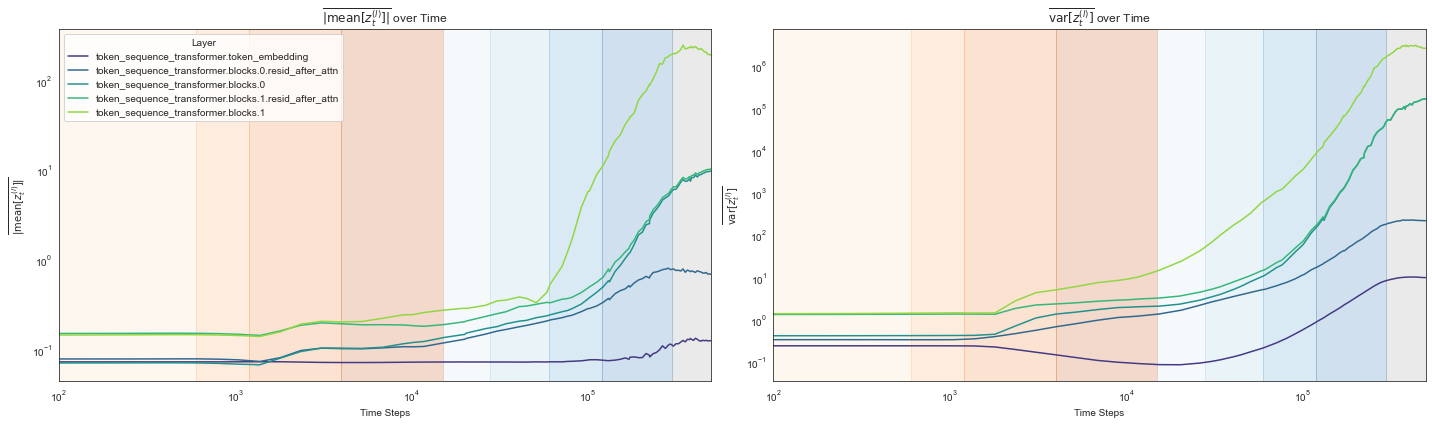

In [294]:
fig, axes = plt.subplots(1, len(more_metrics_to_plot), figsize=(20, 6))

axes = np.array([axes])
# act_stats_over_time = act_stats_over_time[act_stats_over_time["step"] > 0]

for i, (metric_name, key, kwargs) in enumerate(more_metrics_to_plot):
    sns.lineplot(ax=axes[0, i], data=act_stats_over_time, x="step", y=key, hue='layer', palette='viridis')

    axes[0, i].set_title(metric_name + " over Time")
    axes[0, i].set_xlabel('Time Steps')
    axes[0, i].set_ylabel(metric_name)
    axes[0, i].set_yscale('log')

    # sns.lineplot(ax=axes[1, i], data=slopes_df, x="step", y=key, hue='layer', palette='viridis')
    # axes[1, i].set_title(str_d_dlogt(metric_name) + " over Time")
    # axes[1, i].set_xlabel('Time Steps')
    # axes[1, i].set_ylabel(str_d_dlogt(metric_name))
    # axes[1, i].set_yscale('symlog')

    # sns.lineplot(ax=axes[1, i], data=slopes_df, x="step", y=key, hue='layer', palette='viridis')
    # axes[1, i].set_title(metric_name + " Slope over Time")
    # axes[1, i].set_xlabel('Time Steps')
    # axes[1, i].set_ylabel(metric_name + " Slope")


for ax in axes.flatten():
    ax.set_xscale('log')
    ax.set_xlim(100, 500_000)

axes[0, 0].legend(title="Layer")
axes[0, 1].legend().remove()
plot_transitions(axes, transitions=TRANSITIONS)
fig.tight_layout()
fig.set_facecolor("white")

# axes[1, 0].set_ylim(-10, 10)
# axes[1, 1].set_ylim(-5, 5)

# Show the plots
plt.show()


# Mechanistic Interpretability